In [14]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from Functions import Transfer_graphs,preformance_graph_and_prep_2nd_set,create_std_matrix,unpack_dic,create_dictionaries

In [13]:
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
loud=[0,1,0,0,0,1]
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=6
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest = ["H2@100 bar/243K (wt%)"]
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],'topology']]=data[['MOF ID',interest[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],'topology', 'Pc1', 'Pc2', 'Cluster']]

# generate Cluster data sets 
Cluster0=abridge[abridge["Cluster"]==0]
Cluster1=abridge[abridge["Cluster"]==1]
Cluster2=abridge[abridge["Cluster"]==2]
Cluster3=abridge[abridge["Cluster"]==3]
Cluster4=abridge[abridge["Cluster"]==4]
Cluster5=abridge[abridge["Cluster"]==5]
# generate holder for dataframes for looping 
M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]
O_M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]
s_M_Cluster=size_clusters(M_Cluster)
# parameters for neural net
epochs = 500
batch_size = 128
input_size = 5
output_size = 1
resolution=50
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
#Base Cluster for transfer learning 
#specify cluster
cluster=0
data = Cluster0
#checks for index problem
data = data.reset_index(drop=True)
#computer requirements 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = os.getcwd()

features = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
#create splits 
df_train,df_val,df_test=prep_data_splits(data,features,interest)
#create dataset loader objects for looping through data,default test size is .2
first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

third = MyDataset(df_test, interest, features)
test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
#intialize holders for data
train_loss = []
train_r_2 = []
val_loss = []
val_r_2 = []
test_loss = []
test_r_2 = []
net_time = []

# initalize model
model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
criterion = nn.MSELoss()
learning_rate = trial_parameters["lr"]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#Create engine for running NN, pytorch

def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x.to(device))
    loss = criterion(y_pred.to(device), y.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)
#sets up loss and R scores and stores values
#Note: note sure if can condense this into a module b/c of decorator and namespace

@trainer.on(Events.EPOCH_COMPLETED(every=50))
def store_metrics(engine):
    end = time.time()
    e = engine.state.epoch
    out=float(criterion(model(train_loader.dataset.x_train.to(device)),train_loader.dataset.y_train.to(device)))
    out1=float(r2_score(model(train_loader.dataset.x_train.to(device)).detach().numpy(),train_loader.dataset.y_train.to(device).detach().numpy()))
    out2=float(criterion(model(val_loader.dataset.x_train.to(device)),val_loader.dataset.y_train.to(device)))
    out3=float(r2_score(model(val_loader.dataset.x_train.to(device)).detach().numpy(),val_loader.dataset.y_train.to(device).detach().numpy()))
    out4=float(criterion(model(test_loader.dataset.x_train.to(device)),test_loader.dataset.y_train.to(device)))
    out5=float(r2_score(model(test_loader.dataset.x_train.to(device)).detach().numpy(),test_loader.dataset.y_train.to(device).detach().numpy()))
    train_loss.append(out)
    train_r_2.append(out1)
    val_loss.append(out2)
    val_r_2.append(out3)
    test_loss.append(out4)
    test_r_2.append(out5)
    net_time.append(end-start)
    if loud[2]:
        print(e)
#Creates timer and runs trainer 
start = time.time()
trainer.logger.disabled=True
trainer.run(train_loader, max_epochs=epochs)
plt.show()

if loud[3]:
    plt.plot(val_r_2)
    plt.plot(train_r_2,label="t")
    plt.plot(test_r_2,label="real")
    plt.legend()
    plt.show()
    plt.plot(val_loss)
    plt.plot(train_loss,label="t")
    plt.plot(test_loss,label="real")
    plt.legend()
    plt.show()
#save base model for transfer into other clusters in loop
torch.save(model, "Temp.ckpt")
#transfer learning part
#stores meta data
test_loss_holder=[]
test_r2_holder=[]
#loops through clusters
for count,i in enumerate(M_Cluster):
    train_loss = []
    train_r_2 = []
    val_loss = []
    val_r_2 = []
    test_loss = []
    test_r_2 = []
    net_time = []
    #loading model again
    model=torch.load("Temp.ckpt")
    descriptor_columns = [
        "void fraction",
        "Vol. S.A.",
        "Grav. S.A.",
        "Pore diameter Limiting",
        "Pore diameter Largest",
    ]
#turns off model learning
    model.fc1.weight.requires_grad = False
    model.fc1.bias.requires_grad = False
    model.fc2.weight.requires_grad = False
    model.fc2.bias.requires_grad = False

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
    )
    #Base Cluster for transfer learning 
    data = i
    #checks for index problem
    data = data.reset_index(drop=True)
    df_train,df_val,df_test=prep_data_splits(data,features,interest)
    #create dataset loader objects for looping through data,default test size is .2
    first = MyDataset(df_train, interest, features)
    train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

    second = MyDataset(df_val, interest, features)
    val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

    third = MyDataset(df_test, interest, features)
    test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

    #once again making training and testing engine
    def train_step_1(engine, batch):
        x, y = batch
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        return loss.item()


    transfer_trainer = Engine(train_step_1)
    n=int(epochs/resolution)
    @transfer_trainer.on(Events.EPOCH_COMPLETED(every=n))
    def store_metrics(engine):
        e = engine.state.epoch
        end=time.time()
        out=float(criterion(model(train_loader.dataset.x_train.to(device)),train_loader.dataset.y_train.to(device)))
        out1=float(r2_score(model(train_loader.dataset.x_train.to(device),train_loader.dataset.y_train.to(device)))
        out2=float(criterion(model(val_loader.dataset.x_train.to(device)),val_loader.dataset.y_train.to(device)))
        out3=float(r2_score(model(val_loader.dataset.x_train.to(device)),val_loader.dataset.y_train.to(device)))
        out4=float(criterion(model(test_loader.dataset.x_train.to(device)),test_loader.dataset.y_train.to(device)))
        out5=float(r2_score(model(test_loader.dataset.x_train.to(device)),test_loader.dataset.y_train.to(device)))
        end=
        train_loss.append(out)
        train_r_2.append(out1)
        val_loss.append(out2)
        val_r_2.append(out3)
        test_loss.append(out4)
        test_r_2.append(out5)
        net_time.append(end-start)
        if loud[4]:
            print(e)
    #runs model
    transfer_trainer.logger.disabled=True
    transfer_trainer.run(train_loader, max_epochs=epochs)
    test_loss_holder.append(test_loss)
    test_r2_holder.append(test_r_2)
#plots all clusers learning in terms of test set
if loud[5]:
    plt.title(f"base {cluster}")
    for count,i in enumerate(test_loss_holder):
        plt.plot(i,label=f"Cluser {count}")
    plt.legend()
    plt.show()
    plt.title(f"base {cluster}")
    for count,i in enumerate(test_r2_holder):
        plt.plot(i,label=f"Cluser {count}")
    plt.legend()

SyntaxError: invalid syntax (<ipython-input-13-09cce12fccf0>, line 214)

In [17]:
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
loud=[0,0,0,0,0,0]
#make clusters the same size with a random sample
resize=True
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=6
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest = ["H2@100 bar/243K (wt%)"]
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],'topology']]=data[['MOF ID',interest[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],'topology', 'Pc1', 'Pc2', 'Cluster']]

# generate Cluster data sets 
Cluster0=abridge[abridge["Cluster"]==0]
Cluster1=abridge[abridge["Cluster"]==1]
Cluster2=abridge[abridge["Cluster"]==2]
Cluster3=abridge[abridge["Cluster"]==3]
Cluster4=abridge[abridge["Cluster"]==4]
Cluster5=abridge[abridge["Cluster"]==5]
# generate holder for dataframes for looping 
O_M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]
#
# parameters for neural net
epochs = 500
resolution=500
batch_size = 128
input_size = 5
output_size = 1
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
#Base Cluster for transfer learning 
#specify cluster
meta_trials=100
meta=[]
for final,i in enumerate(range(meta_trials)):
    #create holder for meta anaylsis
    mega={}
    if resize:
        M_Cluster=size_clusters(O_M_Cluster)
    else:
        M_Cluster=O_M_Cluster
    for i in range(len(M_Cluster)):
        mega[i]=[]
    for count,g in enumerate(M_Cluster):
        cluster=count
        data = g
        #checks for index problem
        data = data.reset_index(drop=True)
        #computer requirements 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        device=torch.device("cpu")
        base_path = os.getcwd()

        features = [
            "void fraction",
            "Vol. S.A.",
            "Grav. S.A.",
            "Pore diameter Limiting",
            "Pore diameter Largest",
        ]
        #create splits 
        df_train,df_val,df_test=prep_data_splits(data,features,interest)
        #create dataset loader objects for looping through data,default test size is .2
        first = MyDataset(df_train, interest, features)
        train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

        second = MyDataset(df_val, interest, features)
        val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

        third = MyDataset(df_test, interest, features)
        test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
        #intialize holders for data
        train_loss = []
        train_r_2 = []
        val_loss = []
        val_r_2 = []
        test_loss = []
        test_r_2 = []
        net_time = []

        # initalize model
        model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
        criterion = nn.MSELoss()
        learning_rate = trial_parameters["lr"]
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        #Create engine for running NN, pytorch

        def train_step(engine, batch):
            x, y = batch
            model.train()
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            return loss.item()

        trainer = Engine(train_step)
        #sets up loss and R scores and stores values
        #Note: note sure if can condense this into a module b/c of decorator and namespace
        @trainer.on(Events.EPOCH_COMPLETED(every=50))
        def store_metrics(engine):
            end = time.time()
            e = engine.state.epoch
            out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
            out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
            out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
            out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
            out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
            out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
            train_loss.append(out)
            train_r_2.append(out1)
            val_loss.append(out2)
            val_r_2.append(out3)
            test_loss.append(out4)
            test_r_2.append(out5)
            net_time.append(end-start)
            if loud[2]:
                print(e)
        #Creates timer and runs trainer 
        start = time.time()
        trainer.logger.disabled=True
        trainer.run(train_loader, max_epochs=epochs)
        plt.show()

        if loud[3]:
            plt.plot(val_r_2)
            plt.plot(train_r_2,label="t")
            plt.plot(test_r_2,label="real")
            plt.legend()
            plt.show()
            plt.plot(val_loss)
            plt.plot(train_loss,label="t")
            plt.plot(test_loss,label="real")
            plt.legend()
            plt.show()
        #save base model for transfer into other clusters in loop
        torch.save(model, "Temp2.ckpt")
        #transfer learning part
        #stores meta data
        test_loss_holder=[]
        test_r2_holder=[]
        #loops through clusters
        for count,i in enumerate(M_Cluster):
            train_loss = []
            train_r_2 = []
            val_loss = []
            val_r_2 = []
            test_loss = []
            test_r_2 = []
            net_time = []
            #loading model again
            model=torch.load("Temp2.ckpt")
            descriptor_columns = [
                "void fraction",
                "Vol. S.A.",
                "Grav. S.A.",
                "Pore diameter Limiting",
                "Pore diameter Largest",
            ]
        #turns off model learning
            model.fc1.weight.requires_grad = False
            model.fc1.bias.requires_grad = False
            model.fc2.weight.requires_grad = False
            model.fc2.bias.requires_grad = False

            optimizer = optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
            )
            #Base Cluster for transfer learning 
            data = i
            #checks for index problem
            data = data.reset_index(drop=True)
            df_train,df_val,df_test=prep_data_splits(data,features,interest)
            #create dataset loader objects for looping through data,default test size is .2
            first = MyDataset(df_train, interest, features)
            train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

            second = MyDataset(df_val, interest, features)
            val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

            third = MyDataset(df_test, interest, features)
            test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

            #once again making training and testing engine
            def train_step_1(engine, batch):
                x, y = batch
                model.train()
                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                return loss.item()


            transfer_trainer = Engine(train_step_1)
            n=int(epochs/resolution)
            @transfer_trainer.on(Events.EPOCH_COMPLETED(every=n))
            def store_metrics(engine):
                end = time.time()
                e = engine.state.epoch
                out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
                out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
                out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
                out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
                out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
                out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
                train_loss.append(out)
                train_r_2.append(out1)
                val_loss.append(out2)
                val_r_2.append(out3)
                test_loss.append(out4)
                test_r_2.append(out5)
                net_time.append(end-start)
                if loud[4]:
                    print(e)
            #runs model
            transfer_trainer.logger.disabled=True
            transfer_trainer.run(train_loader, max_epochs=epochs)
            test_loss_holder.append(test_loss)
            test_r2_holder.append(test_r_2)
        #because error tends to be low, only anaylizing r2 scores
            mega[count].append(test_r_2)
        #plots all clusers learning in terms of test set
        if loud[5]:
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_loss_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
            plt.show()
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_r2_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
    meta.append(mega)
    print(final)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


KeyboardInterrupt: 

In [18]:
len(meta)

45

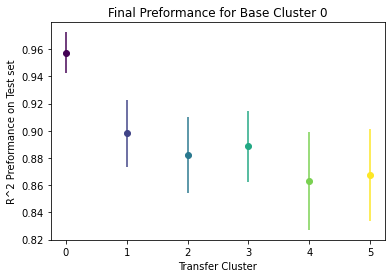

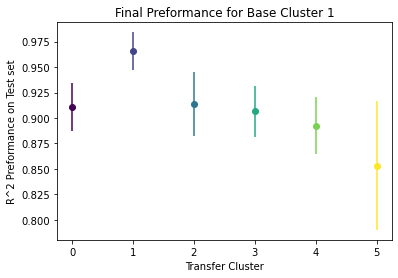

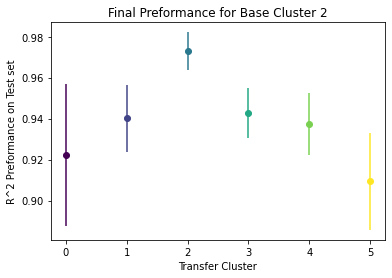

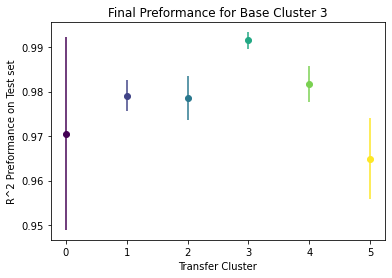

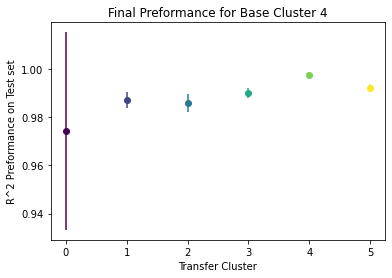

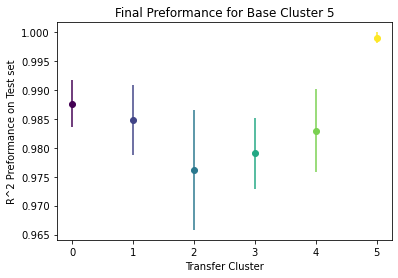

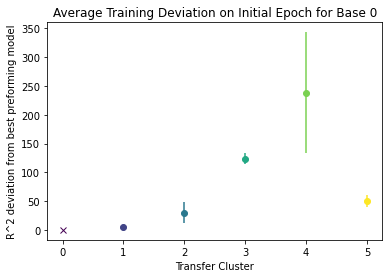

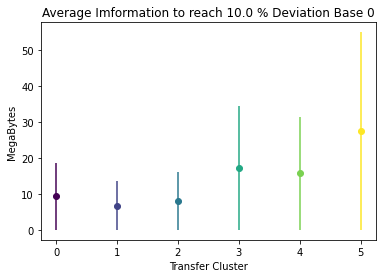

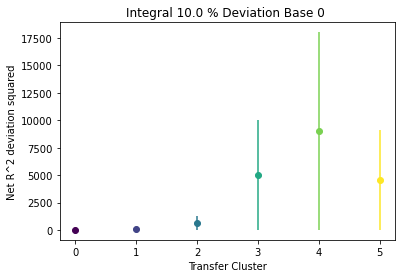

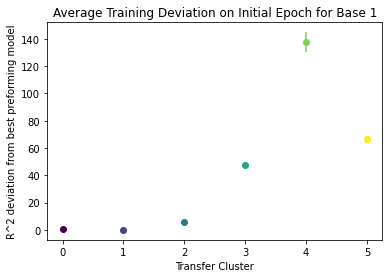

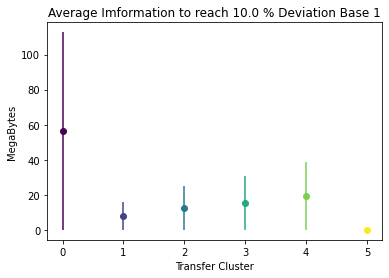

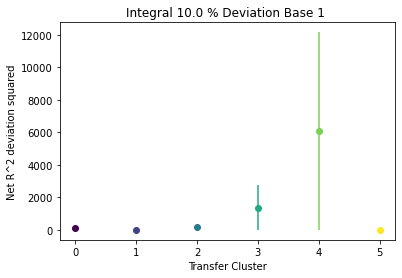

error (2, 0)


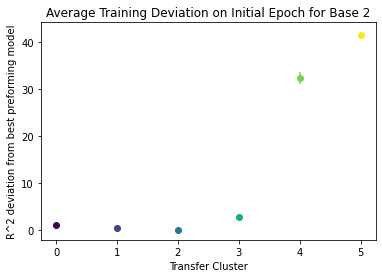

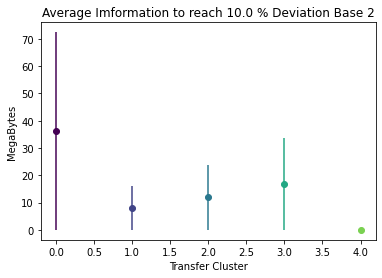

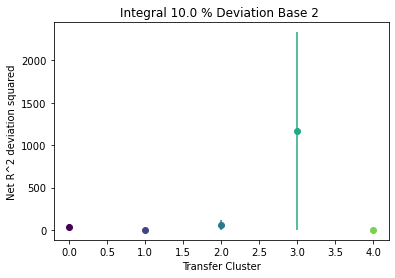

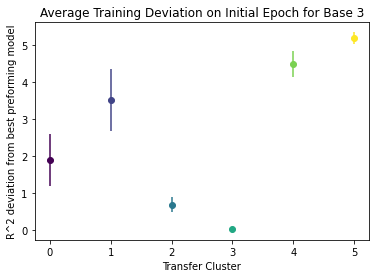

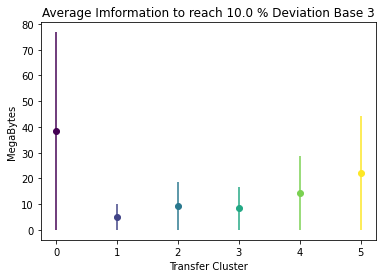

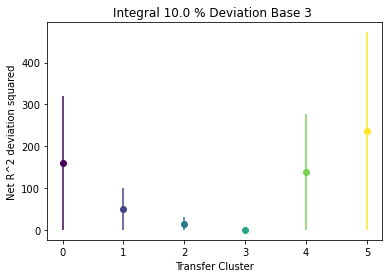

error (4, 5)


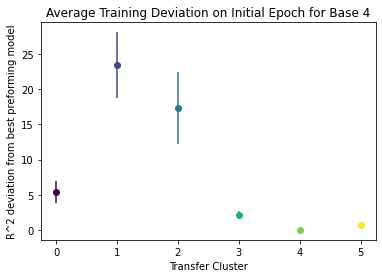

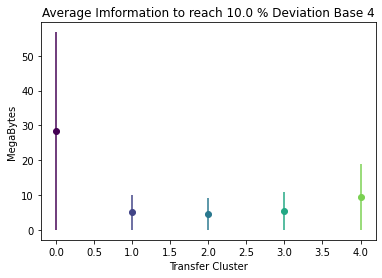

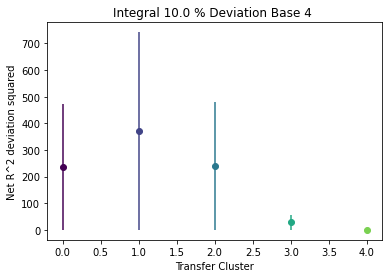

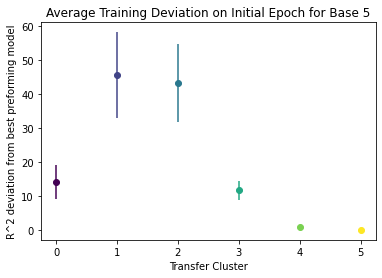

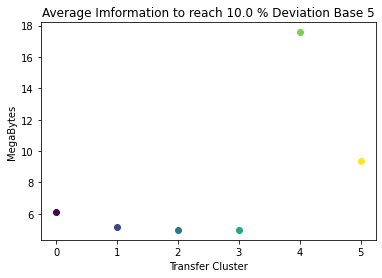

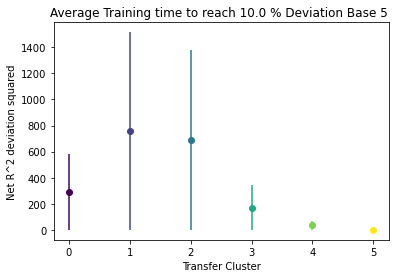

In [19]:
Cluster_colors=[
[0.267004, 0.004874, 0.329415, 1.      ],
[0.253935, 0.265254, 0.529983, 1.      ],
[0.163625, 0.471133, 0.558148, 1.      ],
[0.134692, 0.658636, 0.517649, 1.      ],
[0.477504, 0.821444, 0.318195, 1.      ],
[0.993248, 0.906157, 0.143936, 1.      ],]
dic,dic2,std=create_dictionaries(6)
dic=unpack_dic(dic,meta)
std=create_std_matrix(dic,std)

dic2=preformance_graph_and_prep_2nd_set(Cluster_colors,dic,dic2)
epoch_conversions=[]
byte=df_train.iloc[0].memory_usage()
for i in M_Cluster:
    epoch_conversions.append(len(i))
Transfer_graphs(dic2,resolution,epoch_conversions,Cluster_colors,byte,std)

In [20]:
import itertools
indexer=itertools.product(range(6),range(6))
dic={}
for i in indexer:
    dic[i]=[]
indexer=itertools.product(range(6),range(6))
dic2={}
for i in indexer:
    dic2[i]=[]
std_store={}
for i in indexer:
    std_store[i]=[]

In [21]:
import numpy as np
for i in meta:
    for g in i:
        for count,z in enumerate(i[g]):
            dic[(g,count)].append(z)


In [22]:
for z in dic:
    matrix=np.matrix(dic[z][0])
    for count,i in enumerate(dic[z]):
        if count==0:
            pass
        else:
            i=np.matrix(i)
            matrix=np.concatenate([matrix,i],axis=0)
    matrix=np.matrix(matrix)
    std_store[z]=np.array(matrix.std(axis=0,dtype=float))[0]

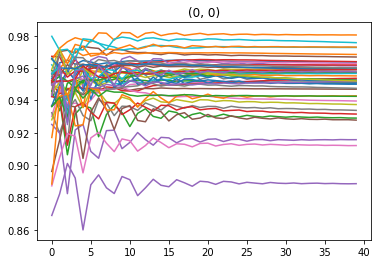

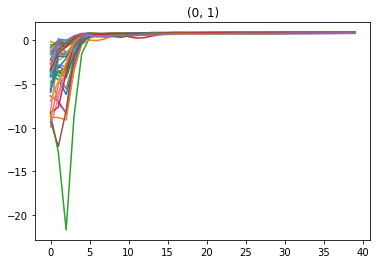

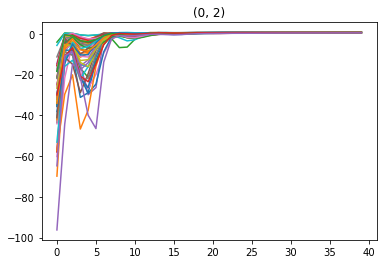

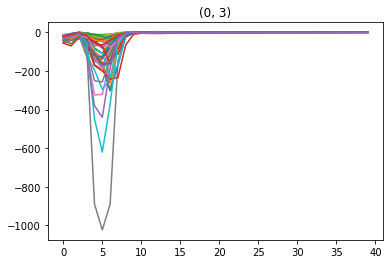

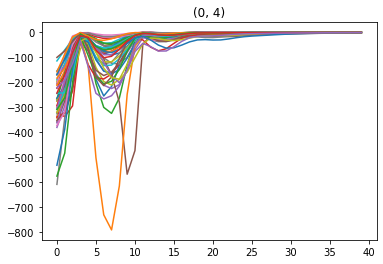

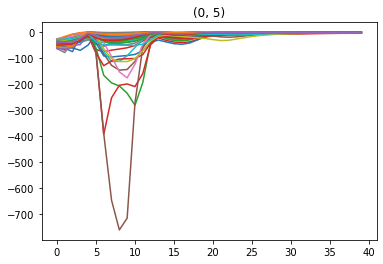

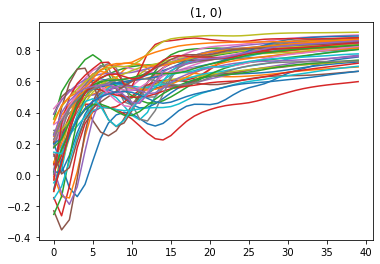

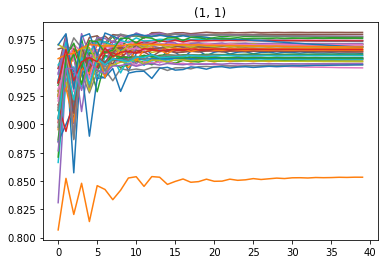

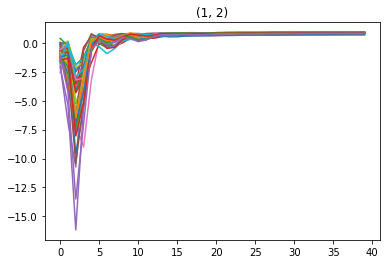

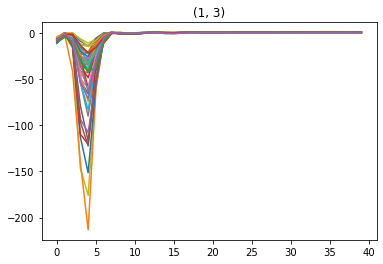

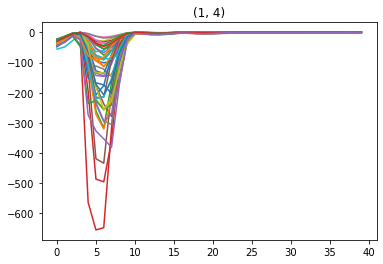

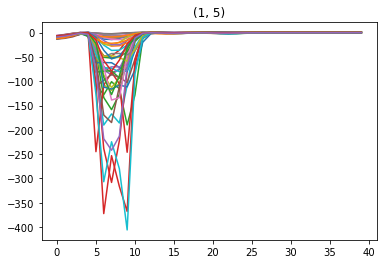

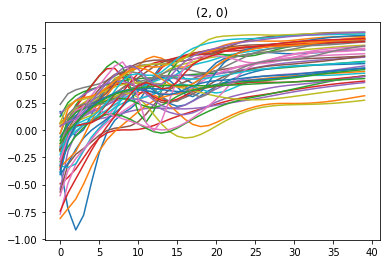

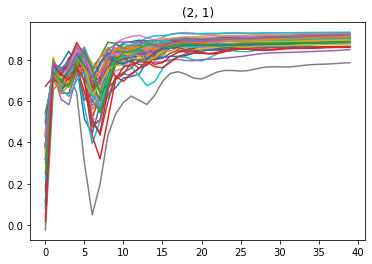

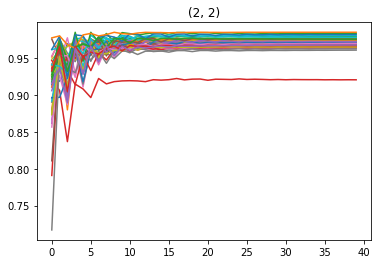

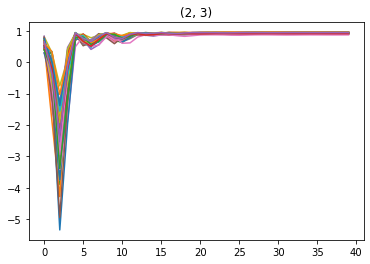

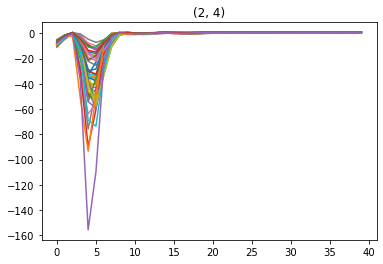

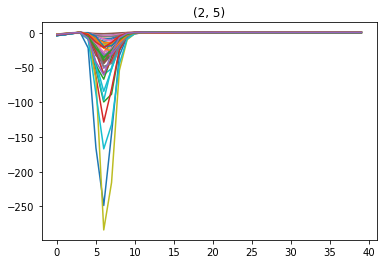

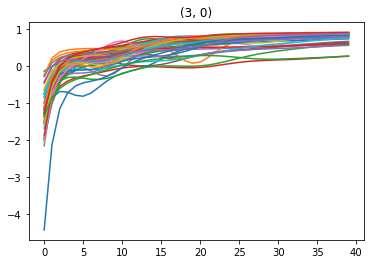

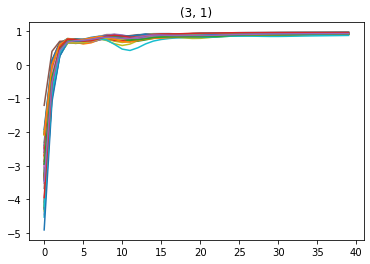

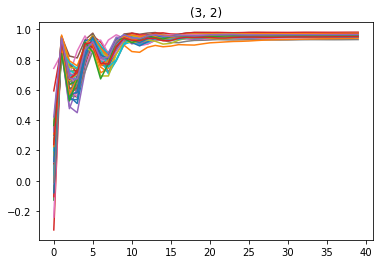

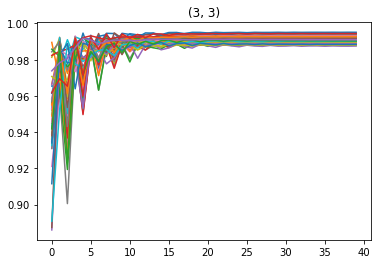

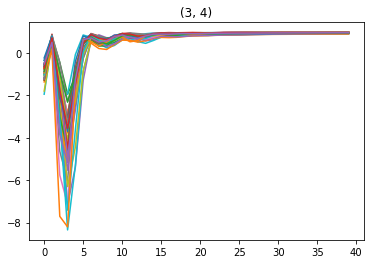

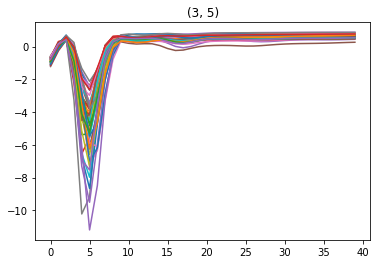

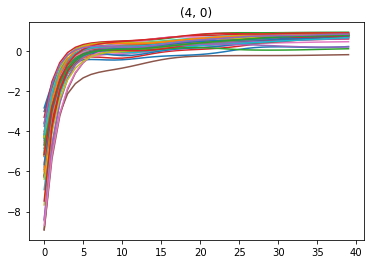

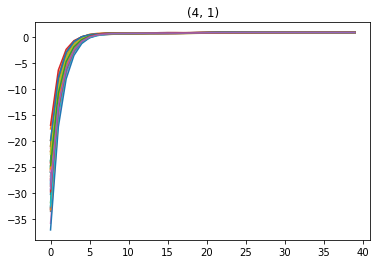

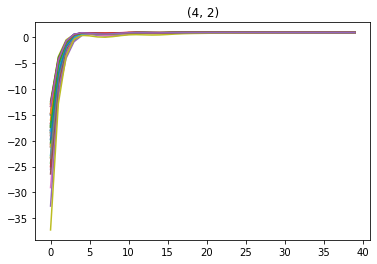

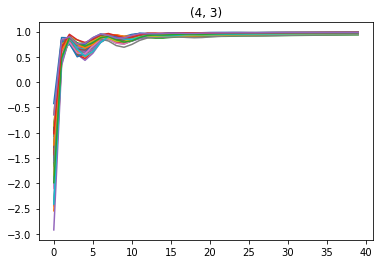

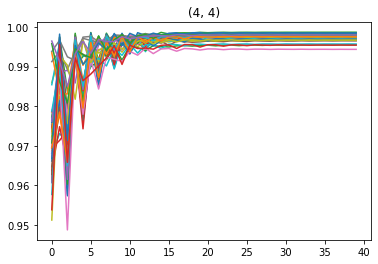

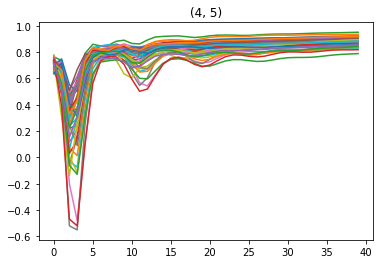

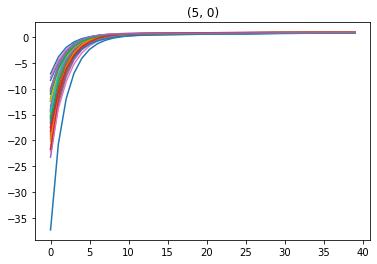

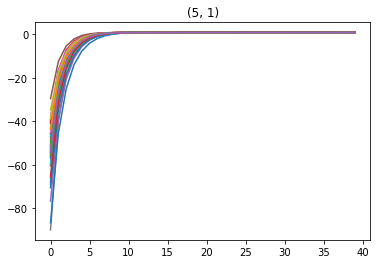

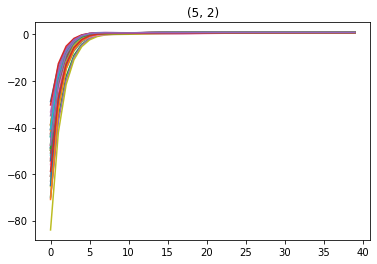

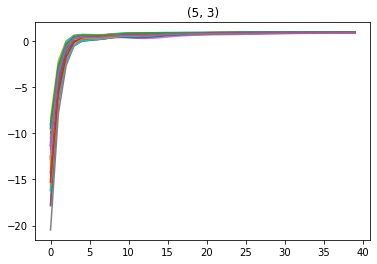

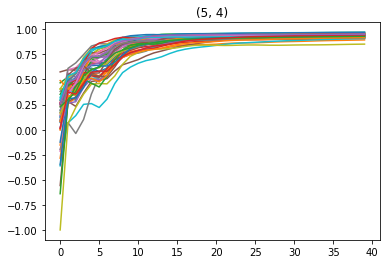

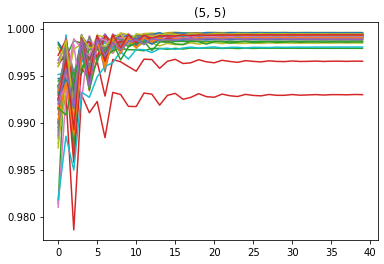

In [33]:
for z in dic:
    for i in range(len(dic[z])):
        plt.title(z)
        plt.plot(dic[z][i][:40])
    plt.show()

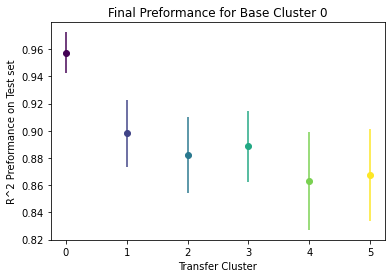

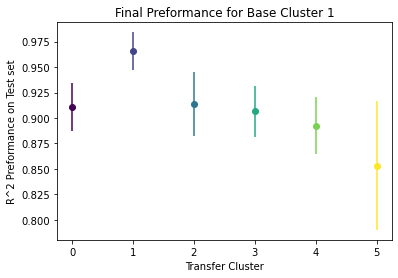

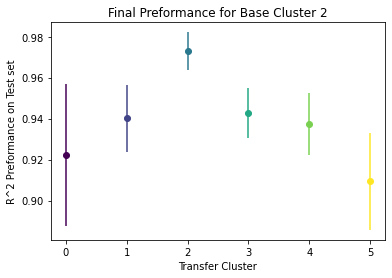

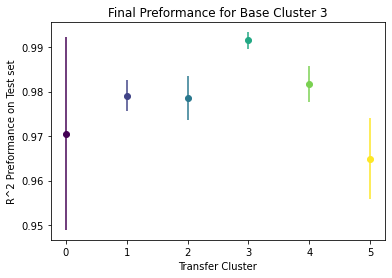

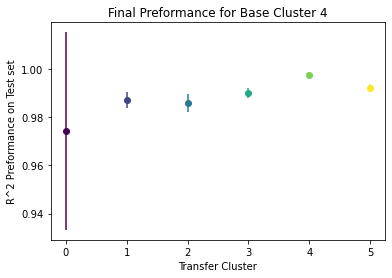

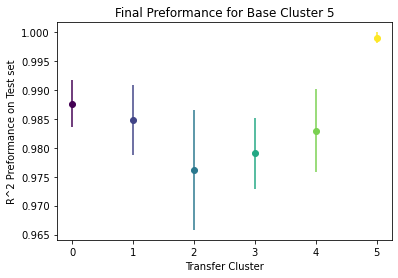

In [24]:
#Cluster_colors=["purple","b","steelblue","teal","lime","gold"]
last=0
adjust=53
Up_max=[]
for i in dic:
    f_index=i[0]
    if f_index is not last:
        for count,z in enumerate(Up_max):
            plt.errorbar(count,z.mean(),yerr=z.std(),fmt="o",c=Cluster_colors[count])
        plt.title(f"Final Preformance for Base Cluster {f_index-1}")
        plt.ylabel("R^2 Preformance on Test set")
        plt.xlabel("Transfer Cluster")
        plt.show()
        Up_max=[]
    store_max=[]
    store_all=[]
    for count,g in enumerate(dic[i]):
        if count==0:
            store_all=np.array(g)
        else:
            store_all=store_all+np.array(g)
        store_max.append(max(g))
    store_max=np.array(store_max)
    store_all=np.array(store_all)
    dic2[i].append((store_all/adjust))
    Up_max.append(store_max)
    last=f_index
for count,z in enumerate(Up_max):
    plt.errorbar(count,z.mean(),yerr=z.std(),fmt="o",c=Cluster_colors[count])
plt.title(f"Final Preformance for Base Cluster {5}")
plt.ylabel("R^2 Preformance on Test set")
plt.xlabel("Transfer Cluster")
plt.show()

error (0, 0)
12.20401688846059 28.197196538885944 16.0 16.0
74.70007976831607 214.60093862163012 77.0 77.0
464.2978353138565 6338.987719139687 100.0 100.0
1027.1760618304213 9640.076176833001 186.0 186.0
498.51748816343513 12768.737887786376 172.0 172.0


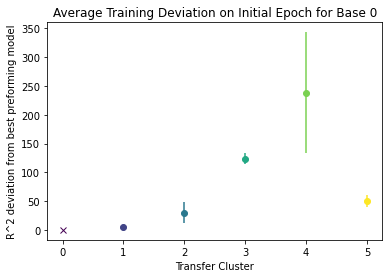

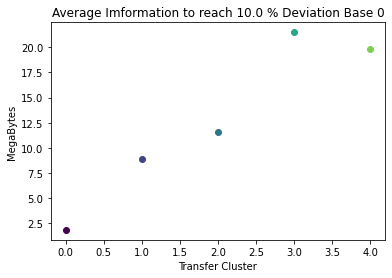

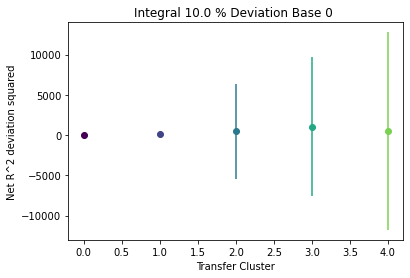

8.150878462333255 13.555891491934823 36.0 36.0
error (1, 1)
16.136279482279658 25.67244559598154 21.0 21.0
128.60601964043187 298.8194515922351 52.0 52.0
572.8958083703782 3984.668375903451 98.0 98.0
361.5390485510694 5083.859115648342 131.0 131.0


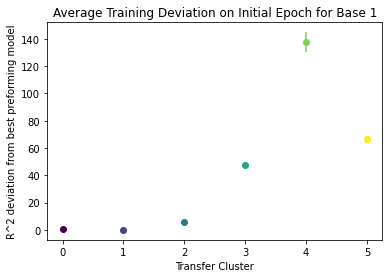

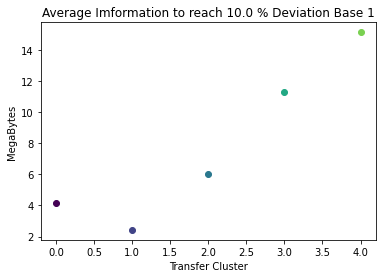

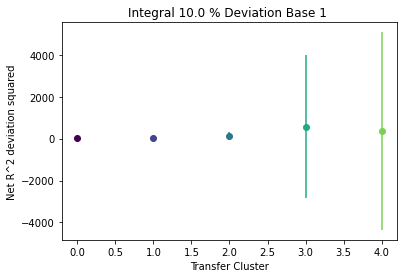

21.949408002629365 38.09501699963637 86.0 86.0
1.9542678490826024 2.975068806249536 13.0 13.0
error (2, 2)
4.466929877904275 6.324552940885118 5.0 5.0
106.70938027888693 184.26443743428658 36.0 36.0
144.2664783592677 2361.893916108241 129.0 129.0


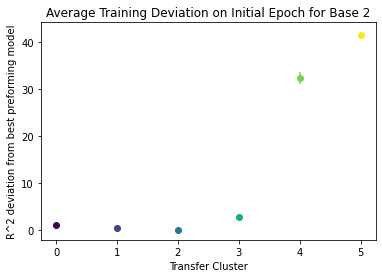

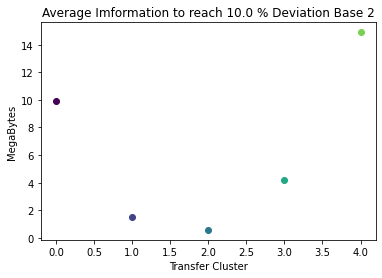

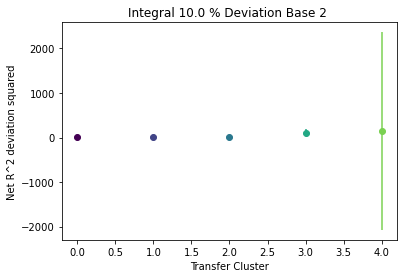

18.86416685597372 30.7951378086986 59.0 59.0
4.780787120856845 6.115716748788851 15.0 15.0
0.0 0.0 2.0 2.0
error (3, 3)
13.079097572394716 18.555154736439434 16.0 16.0
40.28299780781827 59.848717149264985 120.0 120.0


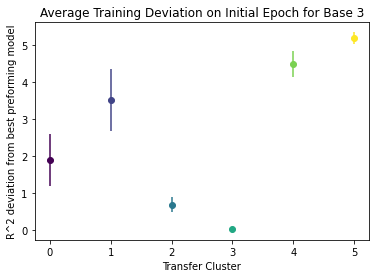

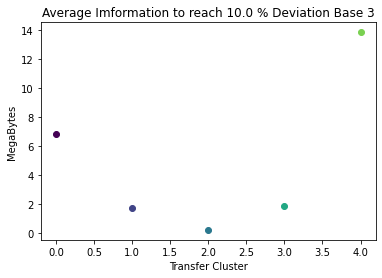

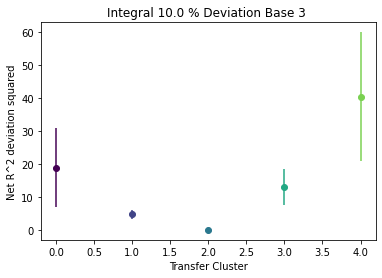

32.05034129014374 55.80490883137804 79.0 79.0
32.9215638136927 40.303718819121144 22.0 22.0
19.273703683179495 25.702048997630268 17.0 17.0
1.8701726899526245 2.483801768191121 7.0 7.0
error (4, 4)
5.977617515947548 8.285095786623845 35.0 35.0


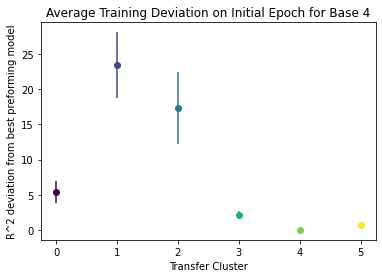

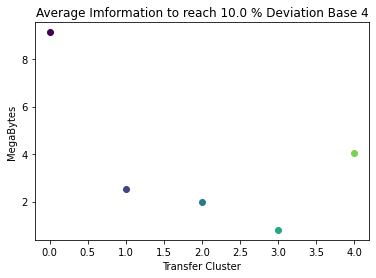

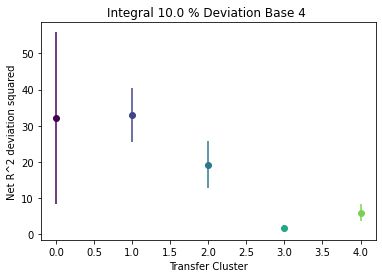

33.263210968473345 44.85897115967067 34.0 34.0
66.6169029181008 88.00003451761721 18.0 18.0
62.2483308173023 83.92693688038099 33.0 33.0
16.57178849177953 22.027509666053714 25.0 25.0
3.1323518433604853 4.444758493867925 13.0 13.0
error (5, 5)


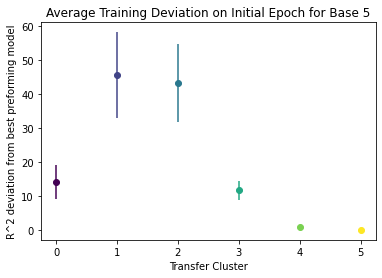

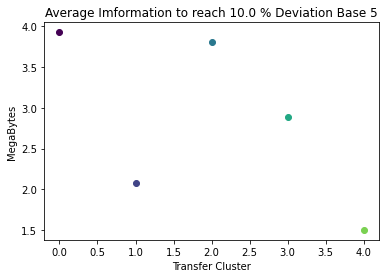

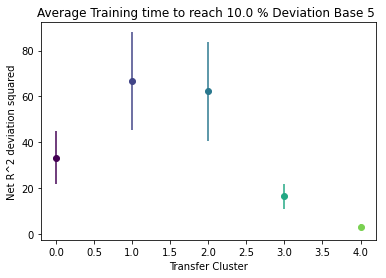

In [35]:
dif_holder=[]
std_diff=[]
overfit_holder=[]
residual_holder=[]
std_res=[]
integral_holder=[]
std_int=[]
last=0
difference=.1
GB=True
for i in dic2:
    f_index=i[0]
    #integral and residual 
    y=(max(dic2[i][0]))-dic2[i][0]
    x=np.linspace(1,epochs,resolution)
    index=np.where(y<(difference))
    ### overfit
    #std_test
    sy=(max(dic2[i][0]+std_store[i]))-dic2[i][0]+std_store[i]
    sx=np.linspace(1,epochs,resolution)
    sindex=np.where(sy<(difference))
    #regular diffs
    diff=max(dic2[i][0])-min(dic2[i][0])
    std1=std_store[i][0]
    #overfit test
    overfit=(dic2[i][0][0]-dic2[i][0][-1]) > 0
    if f_index is not last:
        for count,z in enumerate(dif_holder):
            if overfit_holder[count]:
                plt.errorbar(count,-z,marker="x",c=Cluster_colors[count],yerr=std_diff[count])
            else:
                plt.errorbar(count,z,marker="o",c=Cluster_colors[count],yerr=std_diff[count])
        plt.title(f"Average Training Deviation on Initial Epoch for Base {i[0]-1}")
        plt.ylabel("R^2 deviation from best preforming model")
        plt.xlabel("Transfer Cluster")
        plt.show()
        for count,f in enumerate(residual_holder):
            conversion=epoch_conversions[count]
            f=f*epoch_conversions[count]
            plt.ylabel("Datapoints")
            if GB:
                conversion=conversion*byte*0.000001
                f=f*byte*0.000001 #mega bytes
                plt.ylabel("MegaBytes")
            plt.errorbar(count,f,c=Cluster_colors[count],yerr=std_res[count]*conversion,fmt="o")
        plt.title(f"Average Imformation to reach {difference*100} % Deviation Base {i[0]-1}")
        plt.xlabel("Transfer Cluster")
        plt.show()
        for count,f in enumerate(integral_holder):
            plt.errorbar(count,f,c=Cluster_colors[count],yerr=std_int[count],fmt="o")
        plt.title(f"Integral {difference*100} % Deviation Base {i[0]-1} ")
        plt.ylabel("Net R^2 deviation squared")
        plt.xlabel("Transfer Cluster")
        plt.show()
        dif_holder=[]
        std_diff=[]
        overfit_holder=[]
        residual_holder=[]
        std_res=[]
        integral_holder=[]
        std_int=[]
    dif_holder.append(diff)
    std_diff.append(std1)
    overfit_holder.append(overfit)
    try:
        first=index[0][0]
        sfirst=index[0][0]
        integral=scipy.integrate.simps(y[:first], x=x[:first], dx=1, axis=-1, even='first')
        sintegral=scipy.integrate.simps(sy[:sfirst], x=sx[:sfirst], dx=1, axis=-1, even='first')
        integral_holder.append(integral)
        std_int.append(sintegral-integral)
        print(integral,sintegral,sx[sfirst],x[first])
        residual_holder.append(x[first])
        std_res.append(sx[sfirst]-x[first])
    except:
        print("error", i)
        
    last=f_index
for count,z in enumerate(dif_holder):
    if overfit_holder[count]:
        plt.errorbar(count,-z,marker="x",c=Cluster_colors[count],yerr=std_diff[count])
    else:
        plt.errorbar(count,z,marker="o",c=Cluster_colors[count],yerr=std_diff[count])
plt.title(f"Average Training Deviation on Initial Epoch for Base {5}")
plt.ylabel("R^2 deviation from best preforming model")
plt.xlabel("Transfer Cluster")
plt.show()
for count,i in enumerate(residual_holder):
    coversion=epoch_conversions[count]
    i=i*epoch_conversions[count]
    plt.ylabel("Datapoints")
    if GB:
        conversion=conversion*byte*0.000001
        i=i*byte*0.000001 #mega bytes
        plt.ylabel("MegaBytes")
    plt.errorbar(count,i,c=Cluster_colors[count],yerr=std_res[count]*conversion,fmt="o")
plt.title(f"Average Imformation to reach {difference*100} % Deviation Base {5}")
plt.xlabel("Transfer Cluster")
plt.show()
for count,f in enumerate(integral_holder):
    plt.errorbar(count,f,c=Cluster_colors[count],yerr=std_int[count],fmt="o")
plt.title(f"Average Training time to reach {difference*100} % Deviation Base {5} ")
plt.ylabel("Net R^2 deviation squared")
plt.xlabel("Transfer Cluster")
plt.show()

In [26]:
epoch_conversions=[]
byte=df_train.iloc[0].memory_usage()
for i in M_Cluster:
    epoch_conversions.append(len(i))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.00760768 0.0027553  0.00806141 0.00098279 0.00299691 0.00136486
 0.00089162 0.00066468 0.00120541 0.00054742]


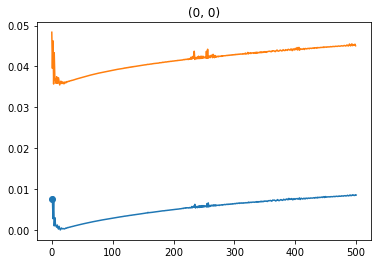

error (0, 0)
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [4.44748811 3.35987906 3.30702028 1.5080828  0.46948602 0.21504512
 0.24667641 0.24666684 0.18186434 0.14680022]


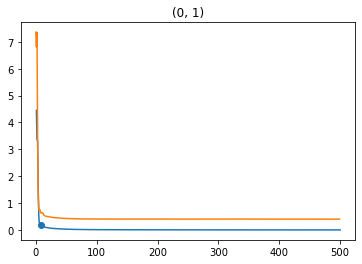

(0, 1) 9.0
11.106406637553535
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [29.59197044  7.116265    4.57034682 10.343608   11.12378099  7.31246357
  2.79274941  1.02848192  0.96296537  1.27900599]


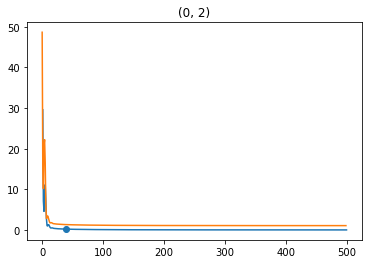

(0, 2) 39.0
69.2891872658855
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [ 24.48865395  17.11217065   6.71099254  34.94492841 101.7945177
 123.63891779  99.73895626  35.3354032    5.64448341   1.52625608]


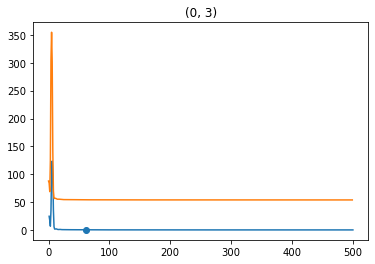

(0, 3) 61.0
458.6706812124701
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [238.20685985 178.49759774  87.55623302  13.20558801  27.94758795
  73.94739171  99.62169471 102.36397482  85.74227856  58.36032925]


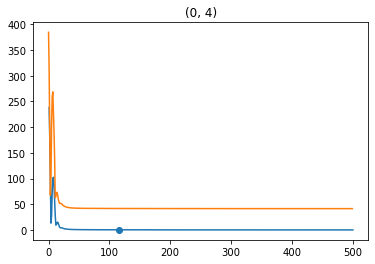

(0, 4) 116.0
1017.0555978206372
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [32.83546744 33.14404673 28.74164396 17.33070739  6.09539893 16.92901532
 40.77100763 47.39880735 49.96459139 48.1255916 ]


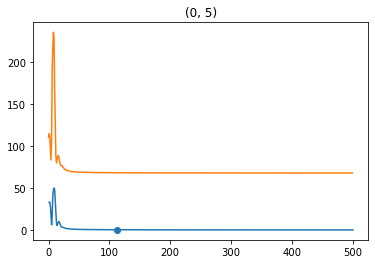

(0, 5) 112.0
489.952171756579
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.67391578 0.59432469 0.50850287 0.42499027 0.35910948 0.31738374
 0.29828867 0.29558401 0.30140553 0.30842762]


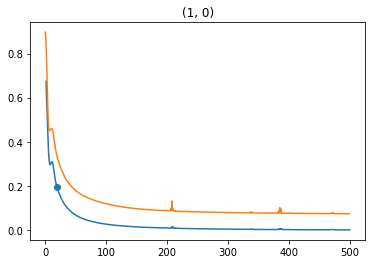

(1, 0) 19.0
5.699396972573236
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.03834992 0.01008868 0.0286146  0.00818399 0.01038804 0.00607434
 0.00570032 0.00308934 0.00224438 0.00218303]


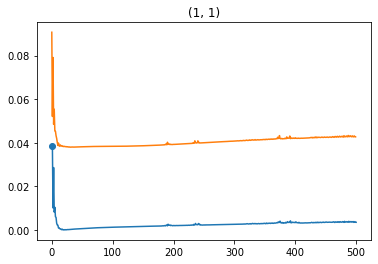

error (1, 1)
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [1.57707944 2.0199582  5.81823743 3.49588227 0.82729476 0.37181886
 0.64857255 0.58618921 0.30147894 0.22603925]


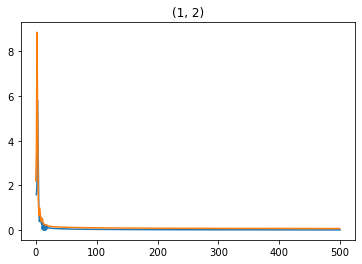

(1, 2) 14.0
15.232670489237208
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [ 6.75053889  1.51217691  5.43451804 35.5700747  47.27346793 20.48597849
  3.76049282  0.47622299  0.70609864  1.13386551]


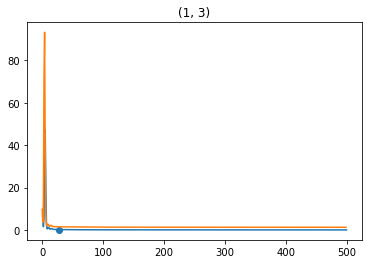

(1, 3) 27.0
125.16538367139924
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [ 27.54259708  18.96845653   7.38422609   5.5291212   64.98084365
 123.83021537 137.34313503 105.32709815  43.26370416   8.83423388]


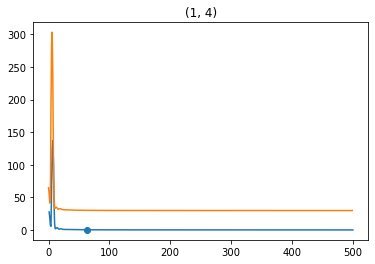

(1, 4) 63.0
567.8703188586533
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [ 8.3355712   6.96524834  4.78984377  1.90197399  2.03313295 32.13031393
 64.93664767 66.62540179 63.31439318 52.0906419 ]


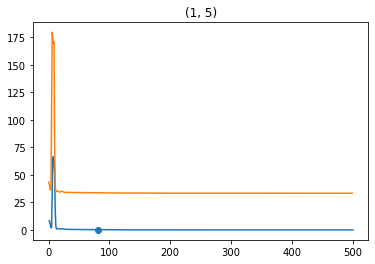

(1, 5) 81.0
354.4232821450867
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.96923665 0.84010872 0.77090206 0.71448004 0.66018756 0.60759263
 0.55774901 0.51398972 0.48281124 0.46862458]


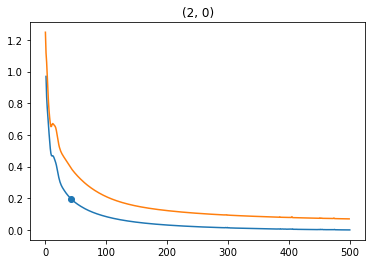

(2, 0) 42.0
15.699925643313586
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.50374882 0.16814091 0.20126679 0.17394565 0.11283758 0.15308733
 0.26041551 0.25063433 0.1607514  0.1182758 ]


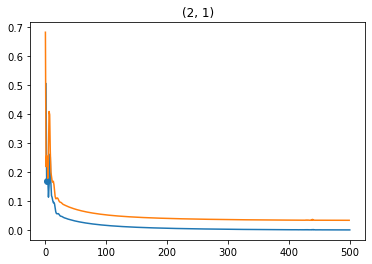

(2, 1) 2.0
0.0
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.052572   0.01445463 0.03668445 0.00884927 0.01688185 0.00606727
 0.00669101 0.00527346 0.00436268 0.00143579]


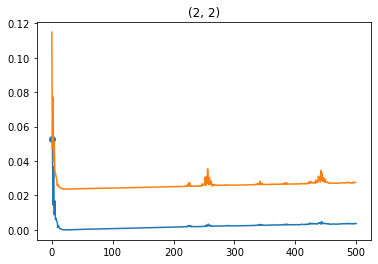

error (2, 2)
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.29700513 1.0964409  2.84199102 1.07536222 0.06641542 0.17959794
 0.29960276 0.15285174 0.03530813 0.11980085]


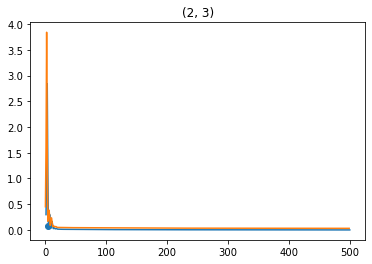

(2, 3) 5.0
4.466929877904275
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [ 7.34931229  3.02913649  0.50307082  9.92499082 32.35934471 31.93035216
 14.11819367  3.56627611  0.59764845  0.48855826]


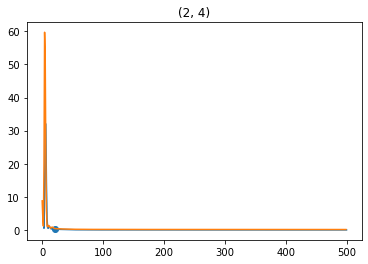

(2, 4) 21.0
104.47148996956955
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [ 3.4249376   2.41145935  1.158589    0.45809679  4.21278718 22.27982034
 41.53553402 30.25051653 11.04233956  2.95917546]


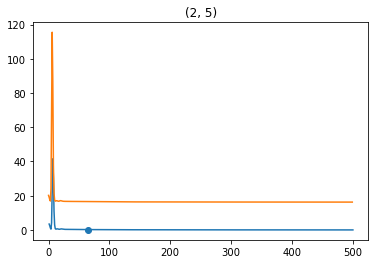

(2, 5) 64.0
135.01761661267994
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [1.89271702 1.23580832 0.94854311 0.81885177 0.75876585 0.72947109
 0.71073923 0.69027815 0.66081272 0.6210554 ]


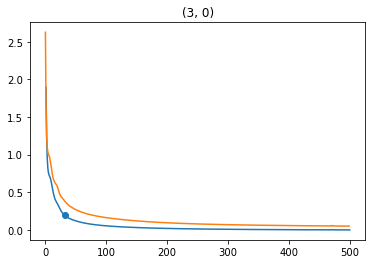

(3, 0) 32.0
15.08952923235241
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [3.51408482 1.10445503 0.38641163 0.22304367 0.21778252 0.22165525
 0.19495685 0.15227321 0.12827783 0.14240772]


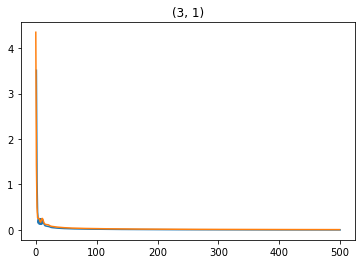

(3, 1) 7.0
3.491280673223334
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.69005788 0.05834681 0.2793395  0.27475949 0.10488998 0.04376115
 0.1301217  0.15794021 0.08233583 0.03042544]


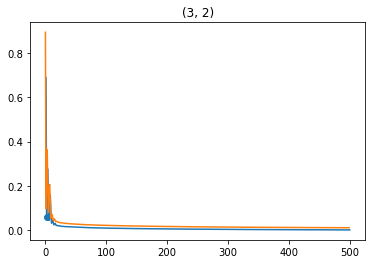

(3, 2) 2.0
0.0
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.0370526  0.01143792 0.0310397  0.00431609 0.01465647 0.00320069
 0.00716716 0.00233302 0.00385755 0.00138241]


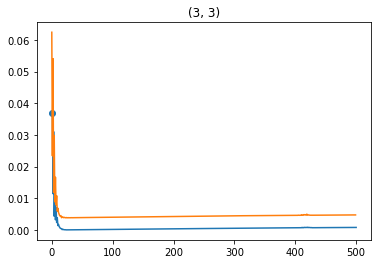

error (3, 3)
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [1.56970206 0.28128329 2.66912507 4.48076452 2.45840856 0.61605617
 0.19882804 0.34060008 0.39950545 0.2727166 ]


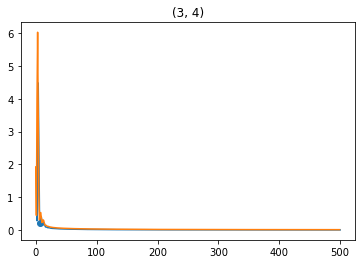

(3, 4) 7.0
11.008749693728555
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [1.54778153 0.79611291 0.39170922 1.38973645 4.03542345 5.17535761
 3.47876445 1.54739163 0.61932571 0.38003971]


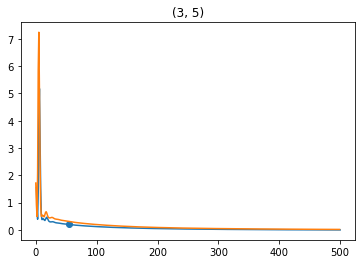

(3, 5) 54.0
30.83782515584513
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [5.37387739 3.28823978 2.14436641 1.50503094 1.14561246 0.94400229
 0.83223885 0.77214605 0.7418818  0.72793128]


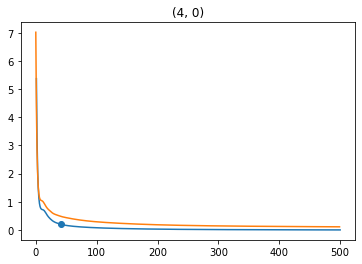

(4, 0) 42.0
26.926652914890738
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [23.41557528 10.6218958   5.07335947  2.47607756  1.22560067  0.63187129
  0.36704394  0.26347262  0.23118845  0.22197819]


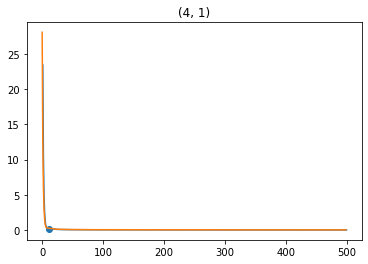

(4, 1) 12.0
31.427982711704406
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [17.31071417  6.65913847  2.35073183  0.70806215  0.22056516  0.1910324
  0.27666698  0.32391485  0.29605016  0.22011364]


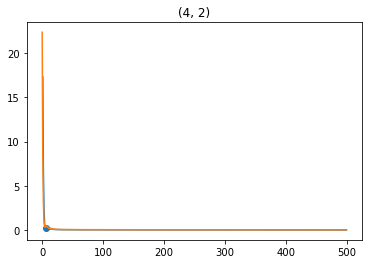

(4, 2) 6.0
17.233848488629384
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [2.11510864 0.29323455 0.11097819 0.26332737 0.29804692 0.20139202
 0.09717873 0.07521274 0.11472953 0.13330457]


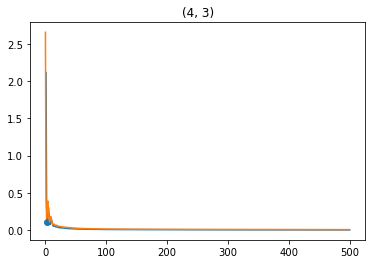

(4, 3) 3.0
1.2041715952231267
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.02096695 0.00824362 0.02259009 0.00227984 0.01095263 0.00199362
 0.00549747 0.00128279 0.00285775 0.00088567]


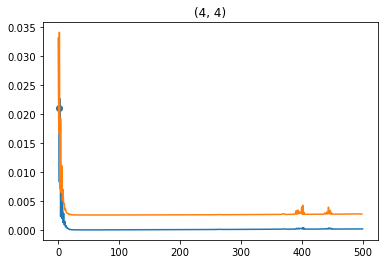

error (4, 4)
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.23614697 0.31902246 0.64645846 0.586334   0.32122092 0.19031236
 0.17221249 0.16866379 0.15751078 0.16599338]


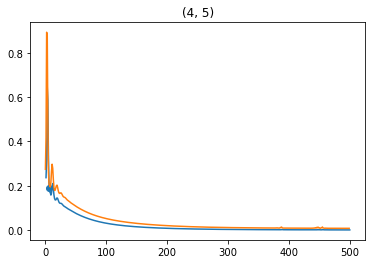

(4, 5) 6.0
1.8239035506597276
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [14.16182646  8.25793541  4.99113513  3.10491842  1.98620781  1.31239852
  0.90396825  0.65629202  0.5063361   0.41531918]


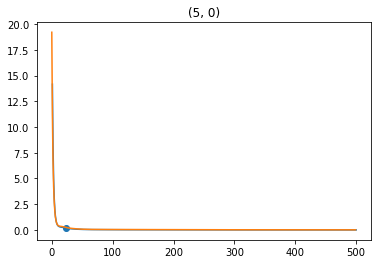

(5, 0) 23.0
31.678596676712743
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [45.64103741 21.75669057 11.16198593  5.94138191  3.20907628  1.73476112
  0.93446963  0.5082671   0.29225394  0.19242206]


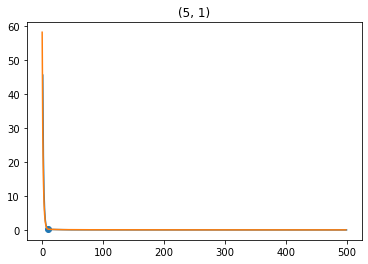

(5, 1) 10.0
65.43625260478426
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [43.31046353 20.11590736  9.60386293  4.57842015  2.15612893  1.03325665
  0.56448444  0.40830476  0.37826935  0.37738547]


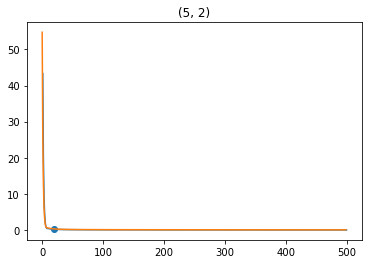

(5, 2) 20.0
60.451132918000056
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [11.71388328  4.46756504  1.68069602  0.71691351  0.47969238  0.46701507
  0.46498293  0.4187871   0.34706387  0.2845644 ]


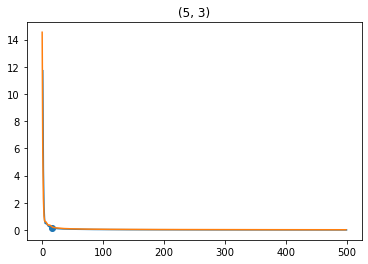

(5, 3) 16.0
15.380699374861093
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.75930659 0.49802646 0.47121822 0.36511399 0.29646463 0.28559405
 0.25290167 0.19118834 0.14698849 0.12717806]


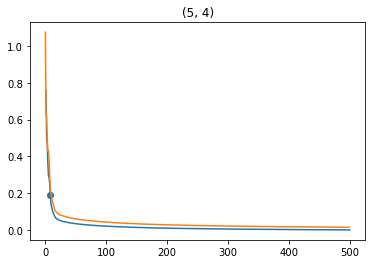

(5, 4) 8.0
2.380837319433192
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.00582387 0.00254133 0.0060852  0.00098131 0.00267227 0.00069867
 0.001476   0.00045713 0.00060905 0.00029118]


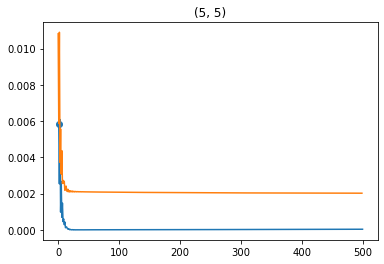

error (5, 5)


In [34]:
import scipy
for i in dic2:
    y=(max(dic2[i][0]))-dic2[i][0]
    x=np.linspace(1,epochs,resolution)
    index=np.where(y<(.2))
    print(x[:10],y[:10])
    try:
        first=index[0][0]
        plt.plot(x,y)
        plt.scatter(x[first],y[first])
        plt.title(i)
        plt.plot((max(dic2[i][0]+std_store[i]))-dic2[i][0]+std_store[i])
        plt.show()
        integral=scipy.integrate.simps(y[:first], x=x[:first], dx=1, axis=-1, even='first')
        print(i,x[first])
        print(integral)
    except:
        print("error", i)

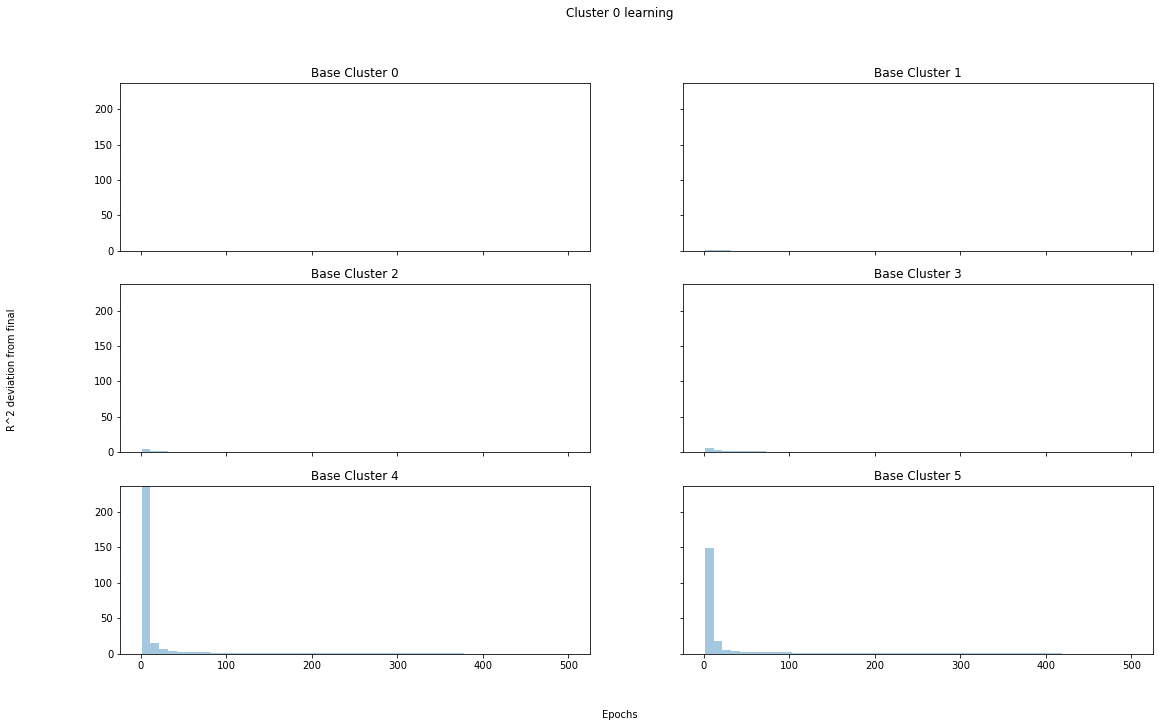

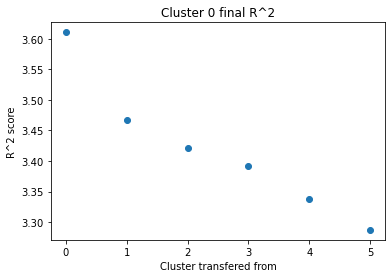

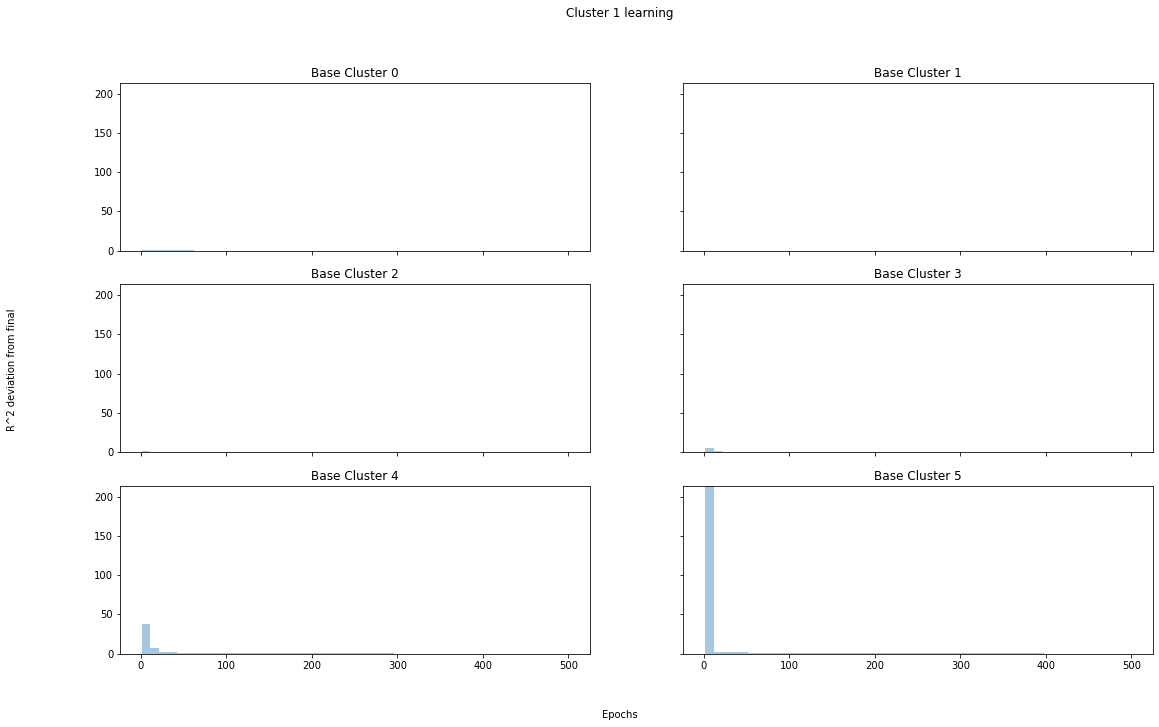

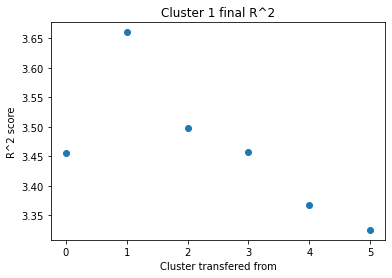

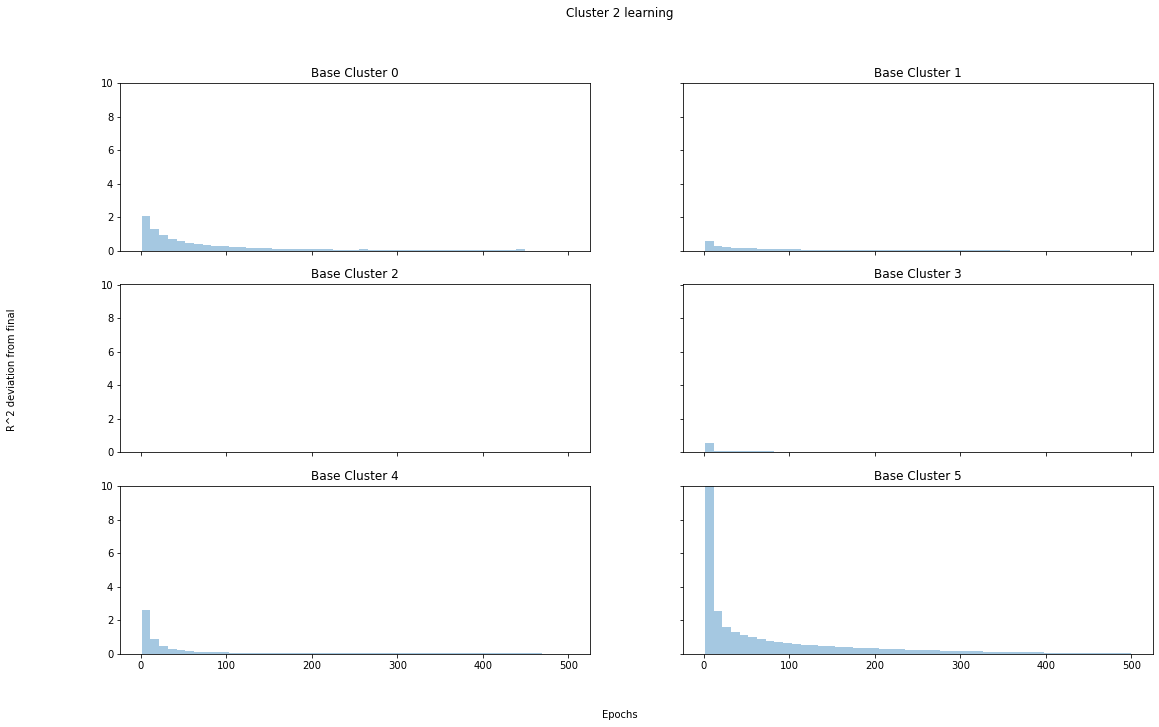

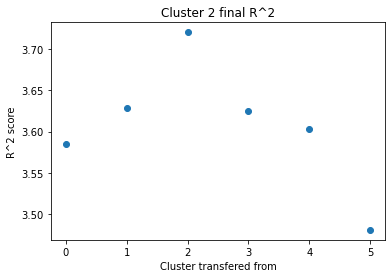

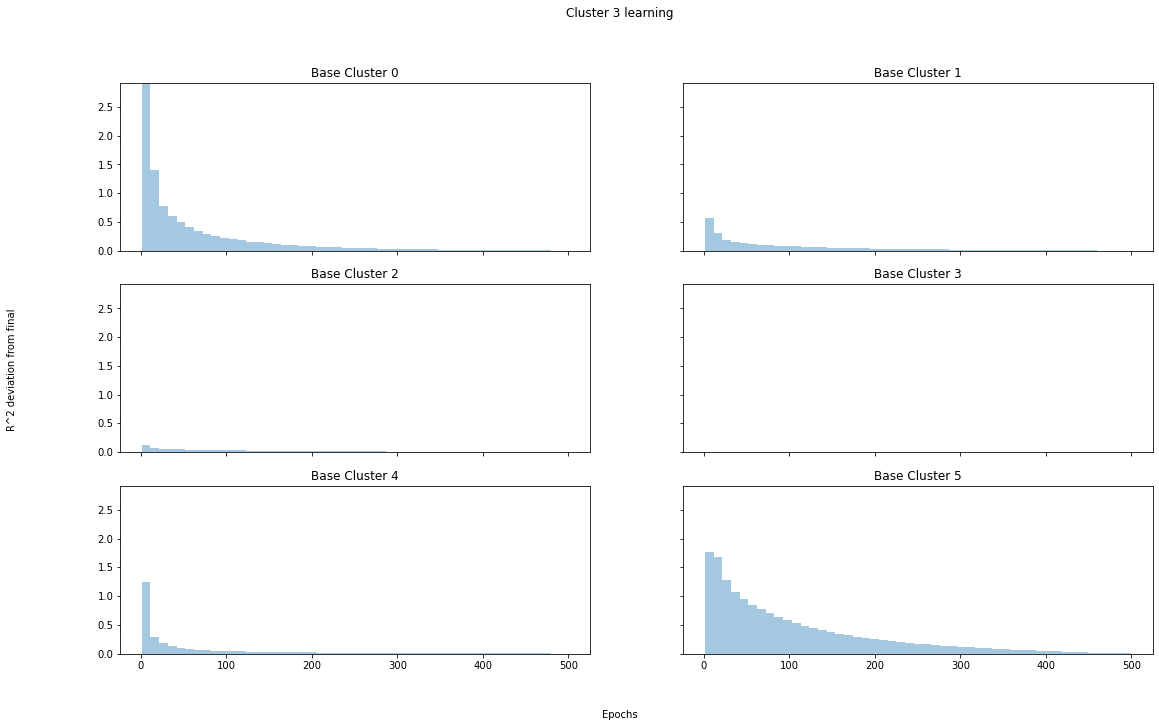

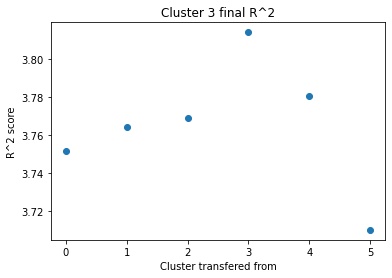

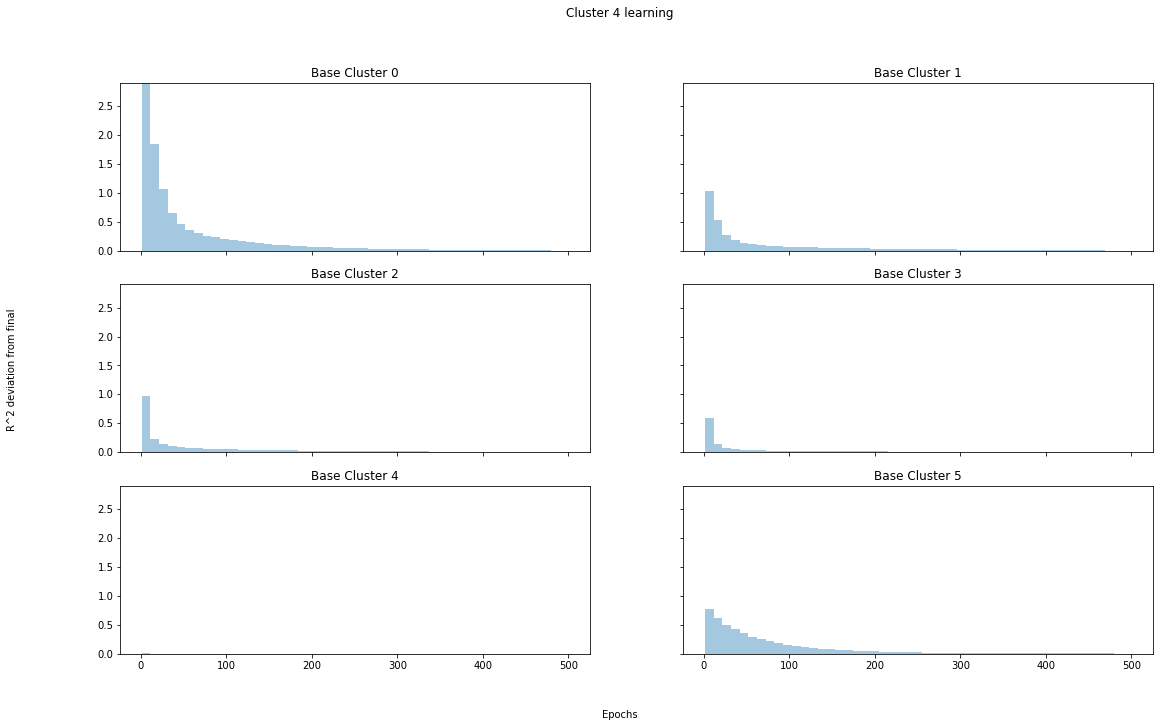

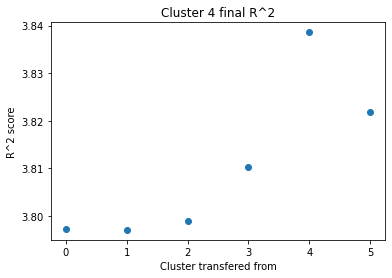

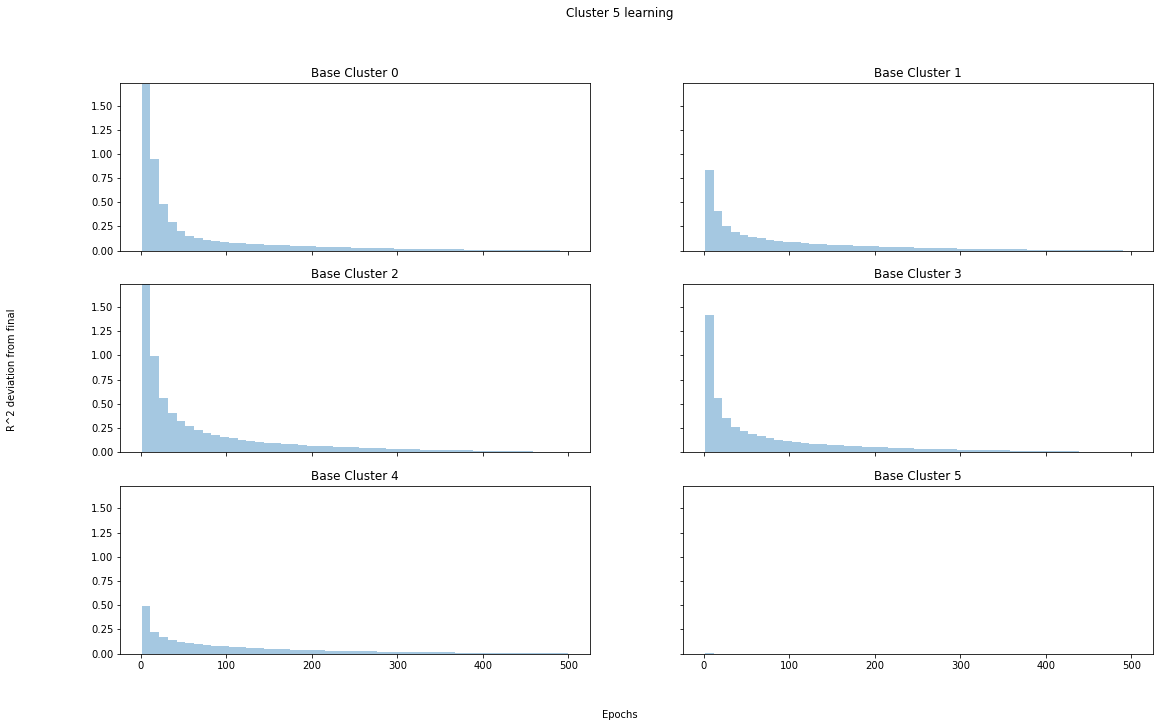

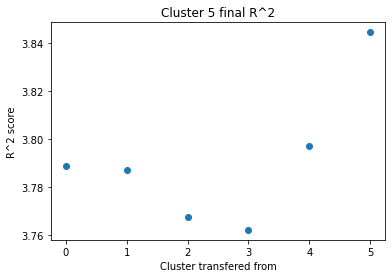

In [14]:
anaylsis(base,adjust=20)

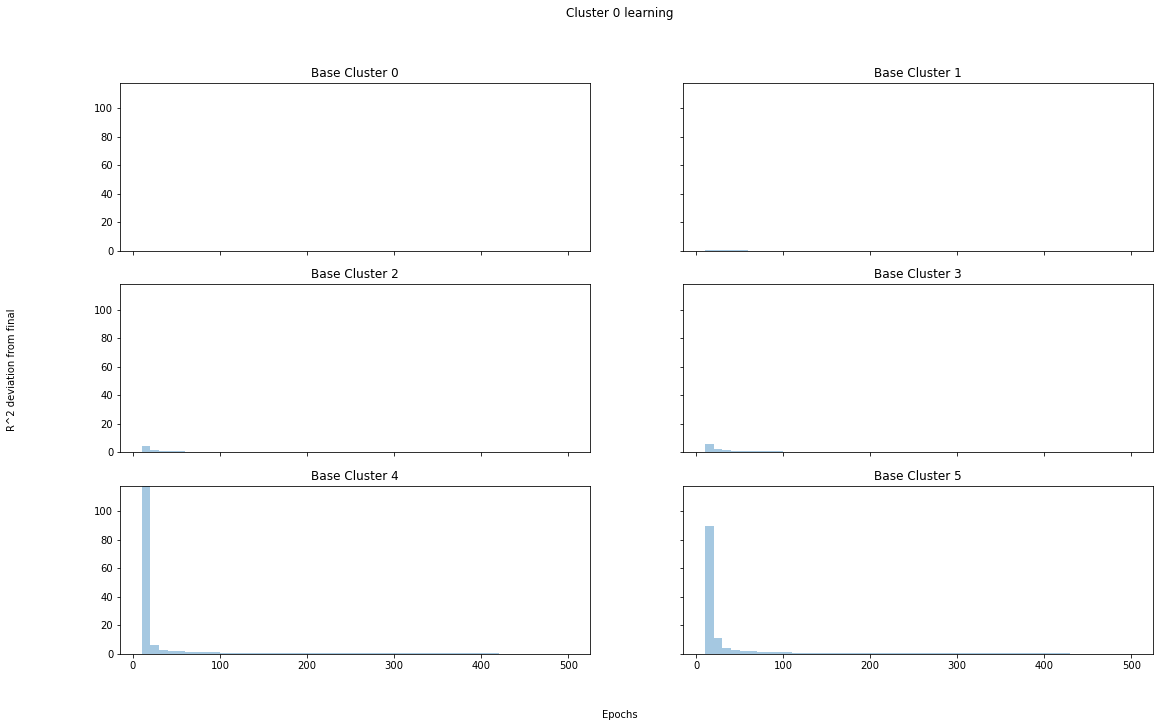

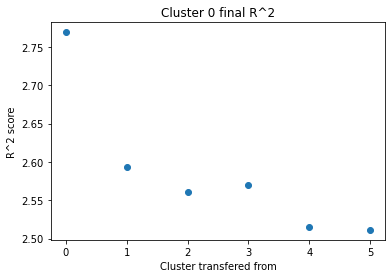

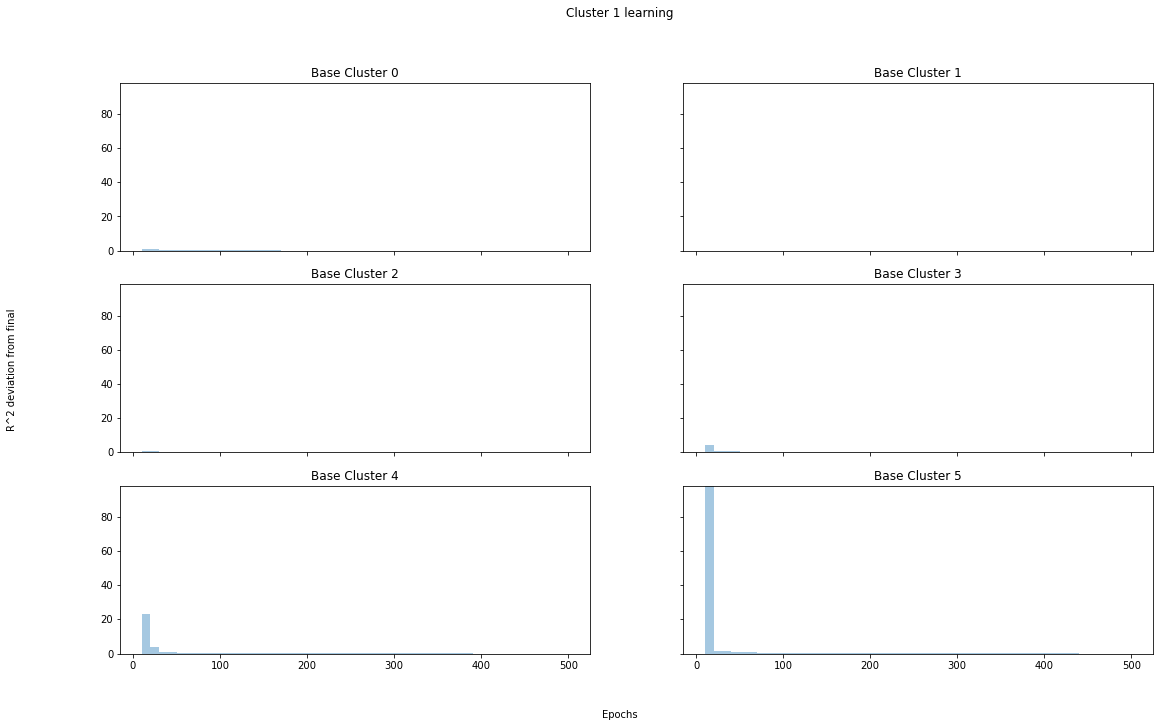

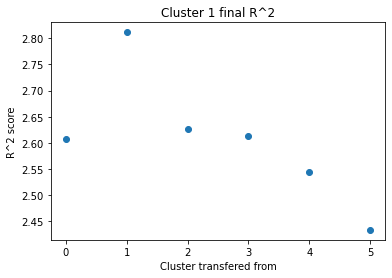

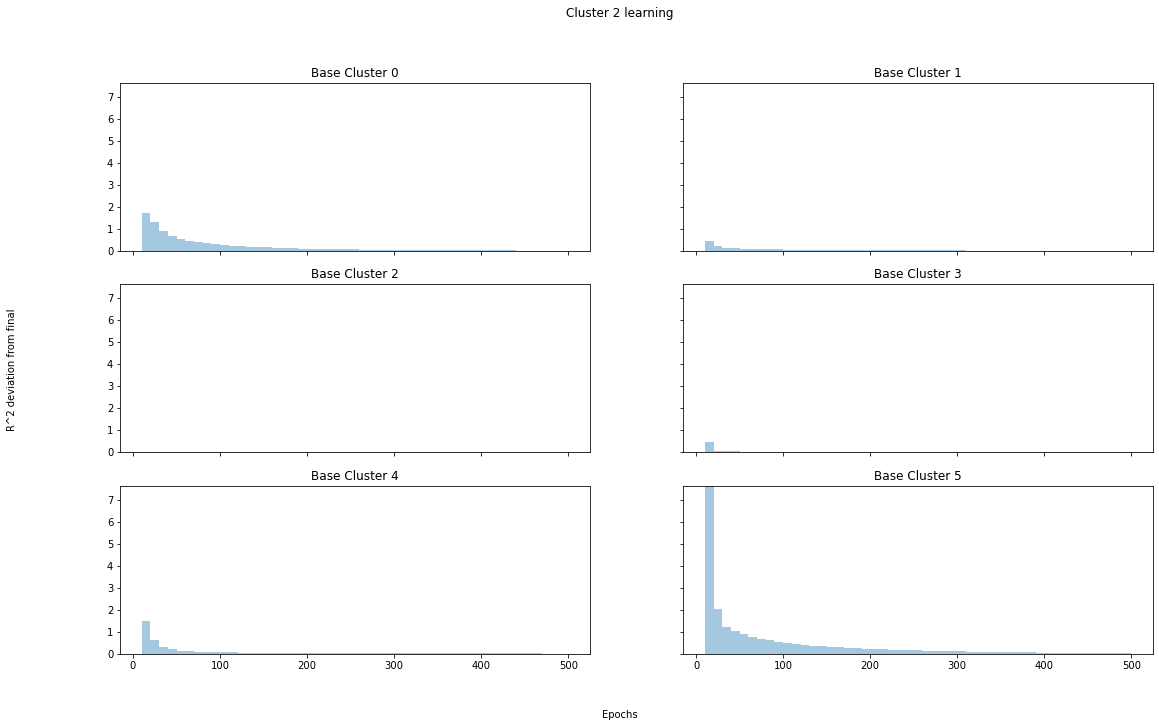

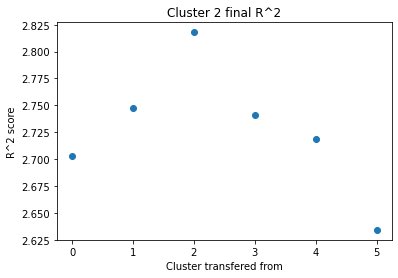

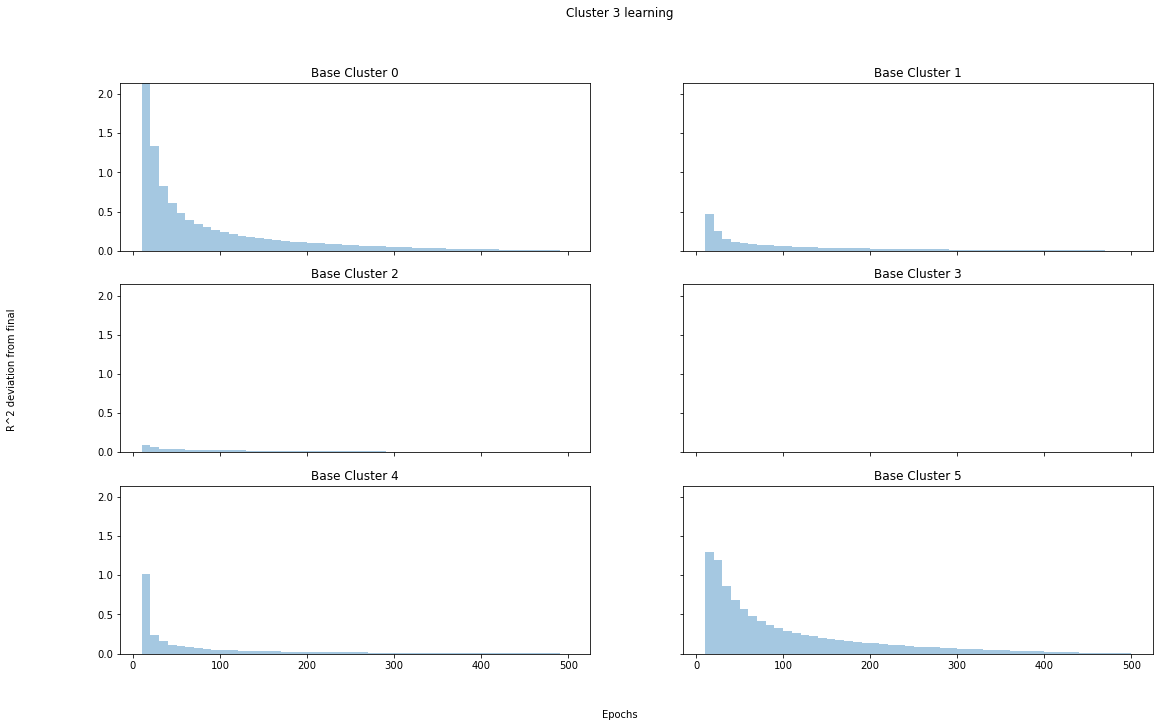

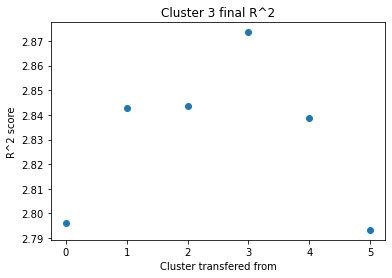

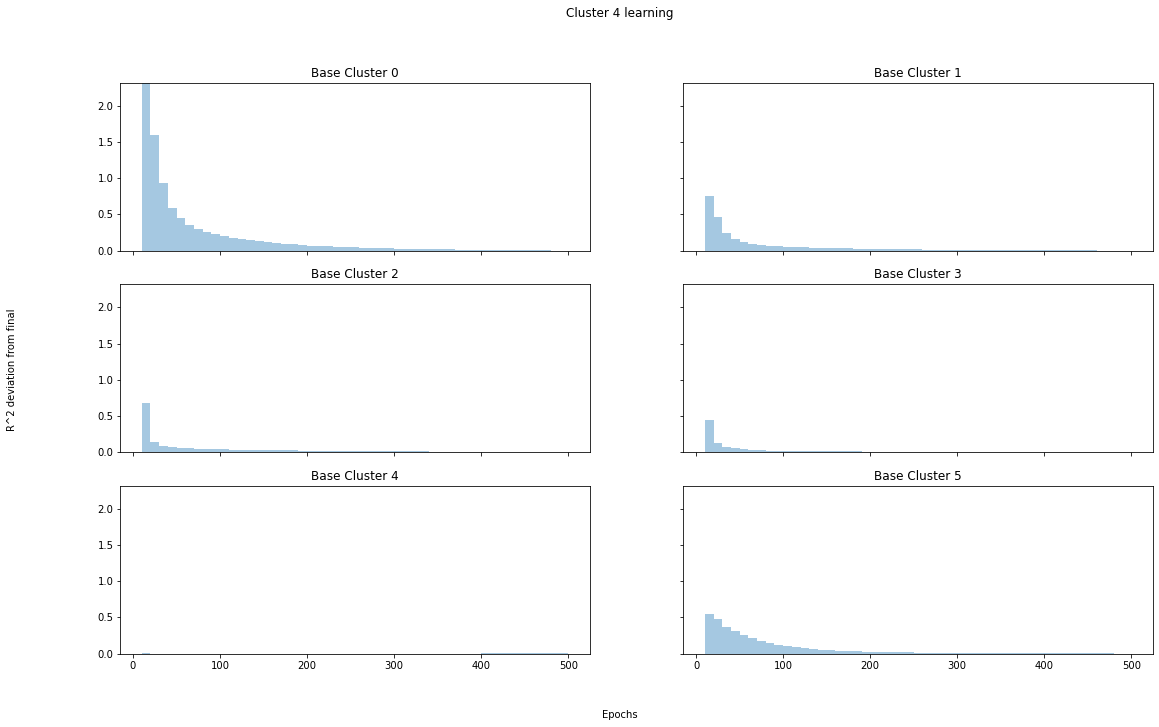

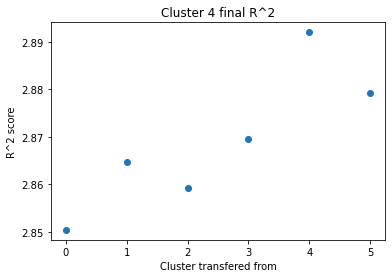

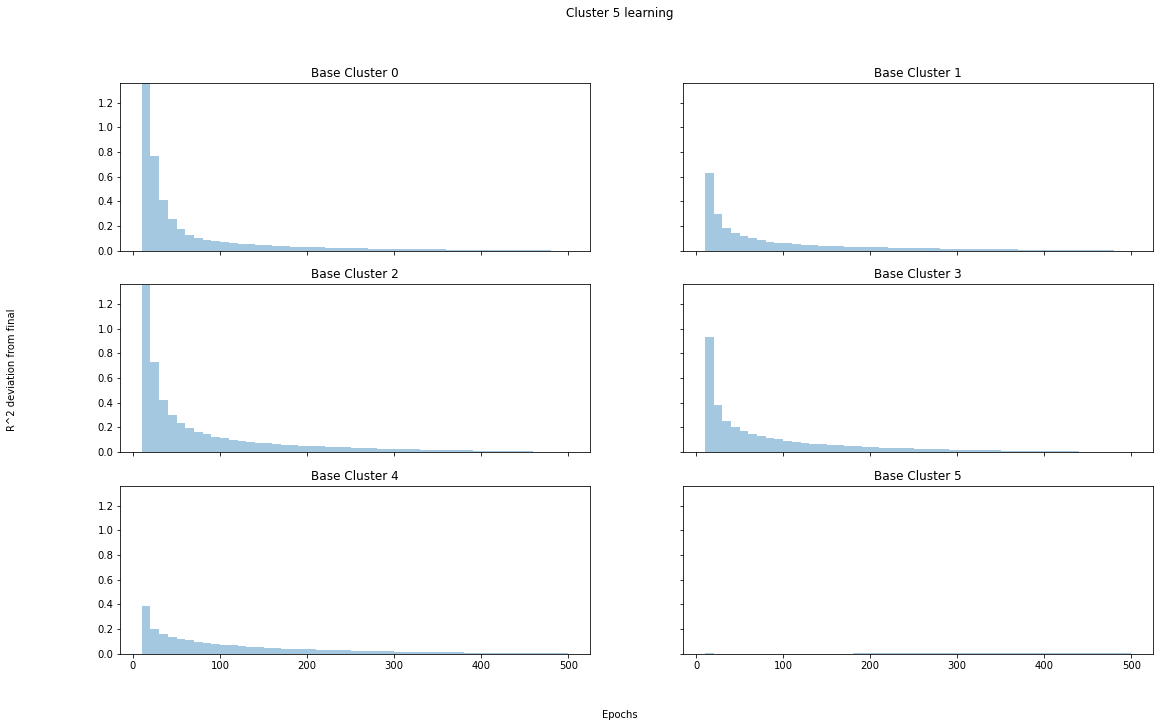

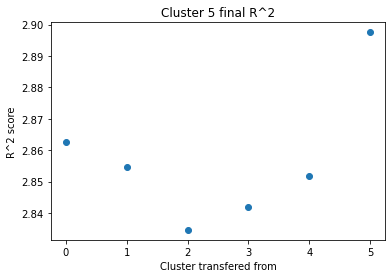

In [27]:
import numpy as np
meta=store
base={}
std={}
for count,i in enumerate((meta[0])):
    i=meta[0][i]
    base[count]=(i)
for i in meta[1:]:
    for g in i:
        for count,z in enumerate(i[g]):
            base[g][count]=np.array(base[g][count])+np.array(z)
mega=base
adjust=20
for count,i in enumerate(mega):
    hold=[]
    for g in mega[i]:
        scatter_holder=[]
        hold.append(np.array(g))
    fig, axs = plt.subplots(int(len(hold)/2),2, sharex=True,sharey=True)
    rotate=0
    base=0
    m_set=0
    min_set=0
    for z in range(len(hold)):
        scatter_holder.append(max(hold[z]))
        if m_set <= max(-(hold[z]-max(hold[z]))):
            m_set=max(-(hold[z]-max(hold[z])))
        if min_set <= min(-(hold[z]-max(hold[z]))):
            min_set=min(-(hold[z]-max(hold[z])))
        axs[base,rotate].fill_between(np.linspace(n,epochs,len(hold[z])),-(hold[z]-max(hold[z]))/adjust, step="post", alpha=0.4,label=f"Base Transfer {z}")
        #axs[base,rotate].scatter(np.linspace(n,epochs,len(hold[z])),-(hold[z]-hold[z][-1]),label=f"Base Transfer {z}")
        fig.suptitle(f"Cluster {count} learning")
        axs[base,rotate].set_title(f"Base Cluster {z}")
        if rotate==1:
            base+=1
            rotate=0
        else:
            rotate+=1
    fig.set_size_inches(18.5, 10.5)
    fig.text(0.04, 0.5, "R^2 deviation from final", va='center', rotation='vertical')
    fig.text(0.5, 0.04, "Epochs", ha='center')
    plt.ylim(min_set/adjust,m_set/adjust)
    plt.show()
    plt.scatter(range(len(scatter_holder)),np.array(scatter_holder)/adjust,label=f"Base Transfer {z}")
    plt.title(f"Cluster {count} final R^2")
    plt.ylabel("R^2 score")
    plt.xlabel("Cluster transfered from")
    plt.show()